# <span style='color:SteelBlue'>P4 - Anticipez les besoins en consommation électrique de bâtiments</span>

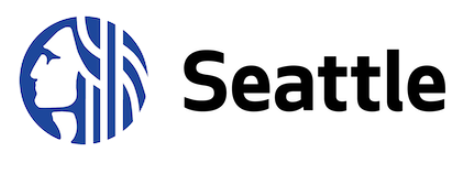

# <span class='bg-primary'>P4_03 - Modélisation Emission des gaz à effet de serre à Seattle</span>

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [11]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## <span style='background:Thistle'>1. Introduction</span>

**Mission**
*****

La **ville de Seattle** souhaite atteindre son objectif de **neutralité carbone** en 2050. Afin de ne pas subir de nouveaux coûts élevés, comme pour les relevés minutieux des campagnes effectuées en **2015** et **2016**, la ville a besoin de **prédictions** pour les **bâtiments** non destinés à l'habitation. 

Les trois objectifs principaux fixés sont :
- **prédire** au moyen d'une modélisation :
    - leurs **émissions GES** (Gaz à Effets de Serre),
    - la **consommation totale d'énergie** des bâtiments,    
- **Evaluer**, pour ces prédictions, la pertinence d'un indicateur d'efficacité énergétique appelé **[Energy Star Score](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/interpret-your-results/what)**.

**Sources**
*****
- [Jeu de données](https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv)
- [Description des variables 2015](https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m)
- [Description des variables 2016](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)

In [21]:
# Chargement des librairies
import datetime
import jyquickhelper
import numpy as np
import pandas as pd
import sys
import pickle
# from math import sqrt

# visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
# from dtreeviz.trees import dtreeviz
# from sklearn import tree
import seaborn as sns
# import folium

# Librairies personnelles
import outils_data
import outils_model
import outils_visu
# import outils_test

# Métriques
# from sklearn.metrics import r2_score
from sklearn.metrics.regression import mean_squared_error as mse
from sklearn.metrics import make_scorer
from hyperopt import hp, fmin, tpe
from hyperopt.pyll import scope

# Scoring - cross-validation
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score

# Data pré-processing
from sklearn.preprocessing import *
from category_encoders import *
from category_encoders import CountEncoder

# Modélisation
from pycaret.regression import *
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Warnings
import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep8
%load_ext pycodestyle_magic
%pycodestyle_on
%pycodestyle_off

# Versions
print('Version des librairies utilisées :')
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Pycaret               : ' + pycaret.__version__)
print('Matplotlib            : ' + mpl.__version__)
print('Seaborn               : ' + sns.__version__)
print('Sklearn               : ' + sklearn.__version__)
print('jyquickhelper         : ' + jyquickhelper.__version__)
print('Outils dataframe      : ' + outils_data.__version__)
print('Outils modèle         : ' + outils_model.__version__)
print('Outils visualisation  : ' + outils_visu.__version__)
# print('Outils test           : ' + outils_test.__version__)
now = datetime.datetime.now().isoformat()
print('Lancé le           : ' + now)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic
Version des librairies utilisées :
Python                : 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
NumPy                 : 1.19.5
Pandas                : 1.2.2
Pycaret               : 2.3.0
Matplotlib            : 3.3.4
Seaborn               : 0.11.0
Sklearn               : 0.23.2
jyquickhelper         : 0.4.220
Outils dataframe      : 0.0.1
Outils modèle         : 0.0.0
Outils visualisation  : 0.0.1
Lancé le           : 2021-04-12T18:02:30.374561


In [3]:
# Options pandas/python
dico_pd_option = {
    'display.max_rows': 400,
    'display.max_column': 200,
    'display.width': 100,
    'display.precision': 5,
    'display.max_colwidth': 200
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)
pd.options.mode.chained_assignment = None  # default='warn'

## <span style='background:Thistle'>2. Chargement des jeux de données</span>

In [4]:
# Chargement du jeu de données prédédemment nettoyé
data = outils_data.read_csv('data_bat_clean.csv')

In [5]:
# Copie du jeu de données dans un dataframe témoin
data_sav = data.copy()

In [6]:
data.columns.to_list()

['SiteEnergyUseWN(kBtu)',
 'SiteEnergyUseWNLog',
 'TotalGHGEmissions',
 'TotalGHGEmissionsLog',
 'ENERGYSTARScore',
 'BuildingType',
 'CouncilDistrictCode',
 'Neighborhood',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'OtherFuelUse(kBtu)',
 'Outlier',
 'Comments',
 'Latitude',
 'Longitude',
 'Address',
 'ZipCode',
 'lat_long_bin',
 'Nb_utilisation',
 'Address_type',
 'TauxParkingGFA',
 'TauxFirstUseGFA',
 'TauxSecondtUseGFA',
 'TauxThirdtUseGFA',
 'BuildingAge']

## <span style='background:Thistle'>3. Première idée sur les modèles avec pycaret</span>

In [7]:
# Préparation des données pour pycaret
data_pycaret = data.copy()
data_pycaret_nofeature = data.copy()
# Données avec les variables de feature engineering
data_pycaret.drop(['ENERGYSTARScore', 'SiteEnergyUseWNLog',
                   'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissionsLog'], 1, inplace=True)
# Données sans les variables de feature engineering
data_pycaret_nofeature.drop(['ENERGYSTARScore', 'SiteEnergyUseWNLog',
                             'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissionsLog',
                             'lat_long_bin', 'Nb_utilisation',
                             'Address_type', 'BuildingAge'], 1, inplace=True)

In [ ]:
data_pycaret.columns.to_list()

**Pycaret sans les features engineering**

In [ ]:
# Initialisation
reg_experiment = setup(data_pycaret_nofeature,
                       target='TotalGHGEmissions',
                       session_id=1525,
                       log_experiment=True,
                       experiment_name='emission_ges')

In [10]:
# Lancement de pycaret sur tous les modèles de régression installés dans notre
# environnement de développement
best_model_sans_feature = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,140.1945,401650.5179,463.9351,0.3210,1.2178,3.2855,0.2300
et,Extra Trees Regressor,115.7398,424024.7207,474.2424,0.3134,0.8474,1.0865,1.2330
llar,Lasso Least Angle Regression,141.9339,443556.7842,488.9798,0.2760,1.2846,4.2482,0.0370
omp,Orthogonal Matching Pursuit,124.6532,473122.1023,510.9751,0.1975,0.9645,1.3873,0.0890
huber,Huber Regressor,136.0635,465229.8144,510.2812,0.1769,1.1265,2.2416,0.0770
rf,Random Forest Regressor,119.2121,388749.1046,467.3359,0.0776,0.8800,1.5820,0.6310
xgboost,Extreme Gradient Boosting,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0340
catboost,CatBoost Regressor,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0160
lightgbm,Light Gradient Boosting Machine,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0230
par,Passive Aggressive Regressor,165.2416,464702.0860,528.5746,-0.0031,1.4078,3.7293,0.0300


In [11]:
# Modèle le plus performant
print(best_model_sans_feature)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1525,
      selection='cyclic', tol=0.0001, warm_start=False)


**Pycaret avec les features engineering**

In [ ]:
# Initialisation
reg_experiment = setup(data_pycaret,
                       target='TotalGHGEmissions',
                       session_id=1525,
                       log_experiment=True,
                       experiment_name='emission_ges')

In [13]:
# Lancement de pycaret sur tous les modèles de régression installés dans notre
# environnement de développement
best_model_avec_feature = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,132.0445,428859.6048,510.3144,0.3836,0.9993,2.1607,4.6540
et,Extra Trees Regressor,131.6464,483953.9654,548.9327,0.2929,0.8384,1.1728,1.5370
lasso,Lasso Regression,164.3845,495897.1170,557.3105,0.2845,1.2723,4.4234,0.1460
llar,Lasso Least Angle Regression,164.2469,559787.1538,588.3658,0.2635,1.3568,6.0075,0.0390
omp,Orthogonal Matching Pursuit,143.9347,618778.7505,622.5530,0.1732,0.9668,1.6741,0.0780
par,Passive Aggressive Regressor,180.1478,569733.9850,600.4897,0.1666,1.4414,4.6160,0.0290
huber,Huber Regressor,158.2208,617515.1905,625.7669,0.1431,1.1937,3.1675,0.0810
gbr,Gradient Boosting Regressor,143.1610,424459.8614,529.3895,0.0976,1.0798,3.0123,0.8680
rf,Random Forest Regressor,140.6239,482643.9497,563.4234,0.0200,0.8839,1.7472,0.8620
en,Elastic Net,207.4716,515253.8003,598.8100,-0.1859,1.4425,6.4926,0.0380


In [14]:
# Modèle le plus performant
print(best_model_avec_feature)

**Bilan** : 
***
- on retrouve le meilleur R2 avec les 2 premiers algorithmes déjà top 3 des algorithmes les plus performants lors de l'analyse de la consommation totale d'energie : CatBoostRegressor et ExtraTreeRegressor mais GradientBoostingRegressor est plus éloigné.
- Les modèles linéaires tirent leurs épingles du jeu. 
- GradientBoostingRegressor obtient la plus faible MSE et donc également un des modèles les plus performants.

## <span style='background:Thistle'>4. Pré-traitement des données</span>

### <span style='background:PowderBlue'>4.1. Matrice X et vecteur y</span>

In [6]:
# Copie du jeu de données
data_prepro = data.copy()

**Energy score**

In [7]:
# Conservation de la variable 'ENERGYSTARScore' pour voir son impact plus tard
cols_energystar = 'ENERGYSTARScore'
energy_star_score = data_prepro[cols_energystar]
# Suppression de cette variable du dataframe à modéliser
data_prepro.drop([cols_energystar], axis=1, inplace=True)

**Catégorisation des variables**

In [8]:
# Variables qualitatives
cols_cat = data_prepro.select_dtypes(exclude=[np.number]).columns.to_list()
cols_cat

['BuildingType',
 'CouncilDistrictCode',
 'Neighborhood',
 'PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'Outlier',
 'Comments',
 'Address',
 'ZipCode',
 'lat_long_bin',
 'Address_type']

In [9]:
# Variables cibles
cols_target = data_prepro.columns[0:4].to_list()
cols_target

['SiteEnergyUseWN(kBtu)',
 'SiteEnergyUseWNLog',
 'TotalGHGEmissions',
 'TotalGHGEmissionsLog']

In [10]:
# Variables quantitatives
cols_num = data_prepro.select_dtypes(include=[np.number]).columns.to_list()
# Suppression des variables cibles
del cols_num[0:4]
cols_num

['NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'OtherFuelUse(kBtu)',
 'Latitude',
 'Longitude',
 'Nb_utilisation',
 'TauxParkingGFA',
 'TauxFirstUseGFA',
 'TauxSecondtUseGFA',
 'TauxThirdtUseGFA',
 'BuildingAge']

**Matrice X**

In [11]:
# Matrice X
X = data_prepro[cols_cat+cols_num]
X.shape

(1722, 28)

**Vecteur y**

In [12]:
# Analyse de la target 'TotalGHGEmissions' non transformée
y = data_prepro['TotalGHGEmissions']
y.shape

(1722,)

In [13]:
# Analyse de la target 'TotalGHGEmissionsLog' en log 10
y_log = data_prepro['TotalGHGEmissionsLog']
y_log.shape

(1722,)

**Nombre aléatoire**

In [14]:
seed = 21
print(f'Nombre aléatoire : {seed}')

Nombre aléatoire : 21


### <span style='background:PowderBlue'>4.2. Découpage du jeu de données en train set et test set</span>

In [15]:
# Découpage du jeu de données en train set et test set
# Target 'TotalGHGEmissions' non transformée
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed)
print(f'X_train : {X_train.shape} - X_test : {X_test.shape}')
print(f'y_train : {y_train.shape} - y_test : {y_test.shape}')

# Target 'TotalGHGEmissionsLog' en log 10
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=seed)
print(f'X_train_log : {X_train_log.shape} - X_test : {X_test_log.shape}')
print(f'y_train_log : {y_train_log.shape} - y_test : {y_test_log.shape}')

X_train : (1377, 28) - X_test : (345, 28)
y_train : (1377,) - y_test : (345,)
X_train_log : (1377, 28) - X_test : (345, 28)
y_train_log : (1377,) - y_test : (345,)


### <span style='background:PowderBlue'>4.3. Encodage des variables qualitatives</span>

In [16]:
# Utilisation de TargetEncoder()
target_encoder = TargetEncoder()

# Target 'TotalGHGEmissions' non transformée
X_train[cols_cat] = target_encoder.fit_transform(X_train[cols_cat], y_train)
X_test[cols_cat] = target_encoder.transform(X_test[cols_cat])

# Sauvegarde de l'encoder
with open('modeles/encoder_target_ges.pickle', 'wb') as f:
    pickle.dump(target_encoder, f, pickle.HIGHEST_PROTOCOL)

In [17]:
# Target 'TotalGHGEmissionsLog' en log 10
target_encoder = TargetEncoder()
X_train_log[cols_cat] = target_encoder.fit_transform(
    X_train_log[cols_cat], y_train_log)
X_test_log[cols_cat] = target_encoder.transform(X_test_log[cols_cat])

# Sauvegarde de l'encoder
with open('modeles/encoder_target_ges_log10.pickle', 'wb') as f:
    pickle.dump(target_encoder, f, pickle.HIGHEST_PROTOCOL)

*Note* :
***
Les tests des différents encodeurs sur la performance du modèle figure au chapitre *9.2. Effet de l'encodage*.

### <span style='background:PowderBlue'>4.4. Standardisation des variables quantitatives</span>

In [18]:
# RobustScaler
scaler_rob = RobustScaler()

# Target 'TotalGHGEmissions' non transformée
X_train[cols_num] = scaler_rob.fit_transform(X_train[cols_num].copy(deep=True))
X_test[cols_num] = scaler_rob.transform(X_test[cols_num].copy(deep=True))

# Sauvegarde de la standardisation
with open('modeles/standardisation_robust_ges.pickle', 'wb') as f:
    pickle.dump(scaler_rob, f, pickle.HIGHEST_PROTOCOL)

In [19]:
# Target 'TotalGHGEmissionsLog' en log 10
scaler_rob = RobustScaler()
X_train_log[cols_num] = scaler_rob.fit_transform(
    X_train_log[cols_num].copy(deep=True))
X_test_log[cols_num] = scaler_rob.transform(
    X_test_log[cols_num].copy(deep=True))

# Sauvegarde de la standardisation
with open('modeles/standardisation_robust_ges_log10.pickle', 'wb') as f:
    pickle.dump(scaler_rob, f, pickle.HIGHEST_PROTOCOL)

*Note* :
***
Les tests des différents scalers sur la performance du modèle figure au chapitre *9.1. Effet de la standardisation*.

## <span style='background:Thistle'>5. Tester différents algorithmes de Machine Learning</span>

Une fonction est réalisée pour entaîner des modèles de régression (avec les hyperparamètres de base) et retourner les scores de performances de ces modèles sur le jeu d'entraînement et le jeu de test.

In [29]:
# Target 'TotalGHGEmissions' non transformée
df_comp = outils_model.comparer_baseline_regressors(X_train, y_train)
df_comp.style.hide_index()

Exécution terminée - Modèle : dum_mean
Exécution terminée - Modèle : dum_med
Exécution terminée - Modèle : lin
Exécution terminée - Modèle : ridge
Exécution terminée - Modèle : lasso
Exécution terminée - Modèle : en
Exécution terminée - Modèle : svr
Exécution terminée - Modèle : br
Exécution terminée - Modèle : hr
Exécution terminée - Modèle : omp
Exécution terminée - Modèle : lars
Exécution terminée - Modèle : knr
Exécution terminée - Modèle : dt
Exécution terminée - Modèle : ada
Exécution terminée - Modèle : xgb
Exécution terminée - Modèle : sgd
Exécution terminée - Modèle : lgbm
Exécution terminée - Modèle : rfr
Exécution terminée - Modèle : etr
Exécution terminée - Modèle : cat
Exécution terminée - Modèle : gbr
Exécution terminée - Modèle : bag


Modèle,Fit time,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
gbr,0.22170,0.00204,0.50796,0.28790,322906.67486,0.97995,0.00287,11851.63267
rfr,0.81105,0.00746,0.45820,0.28818,315835.20081,0.92856,0.01426,43068.44183
cat,1.58571,0.00568,0.45432,0.33940,337407.65192,0.99522,0.00061,2835.54724
xgb,0.11255,0.00391,0.40880,0.36674,324963.05078,0.99959,0.00007,242.56625
etr,0.53948,0.00988,0.39712,0.41029,320799.36113,1.00000,0.00000,0.00000
bag,0.08369,0.00091,0.39519,0.21708,379306.53478,0.90108,0.04210,60358.07527
lgbm,0.07563,0.00175,0.30617,0.49132,366041.94403,0.81954,0.01748,107434.05433
hr,0.04034,0.00180,0.19023,0.08228,514306.86249,0.16333,0.02280,503227.74545
omp,0.00281,0.00041,0.05540,0.42330,481400.53397,0.31828,0.05321,410478.06099
dum_mean,0.00000,0.00162,-0.01581,0.02657,601421.98242,0.00000,0.00000,601433.80312


In [30]:
# Target 'TotalGHGEmissionsLog' en log 10
df_comp_log = outils_model.comparer_baseline_regressors(
    X_train_log, y_train_log)
df_comp_log.style.hide_index()

Exécution terminée - Modèle : dum_mean
Exécution terminée - Modèle : dum_med
Exécution terminée - Modèle : lin
Exécution terminée - Modèle : ridge
Exécution terminée - Modèle : lasso
Exécution terminée - Modèle : en
Exécution terminée - Modèle : svr
Exécution terminée - Modèle : br
Exécution terminée - Modèle : hr
Exécution terminée - Modèle : omp
Exécution terminée - Modèle : lars
Exécution terminée - Modèle : knr
Exécution terminée - Modèle : dt
Exécution terminée - Modèle : ada
Exécution terminée - Modèle : xgb
Exécution terminée - Modèle : sgd
Exécution terminée - Modèle : lgbm
Exécution terminée - Modèle : rfr
Exécution terminée - Modèle : etr
Exécution terminée - Modèle : cat
Exécution terminée - Modèle : gbr
Exécution terminée - Modèle : bag


Modèle,Fit time,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
gbr,0.22147,0.00265,0.71669,0.04637,0.11801,0.82283,0.00401,0.07404
etr,0.78122,0.01412,0.70708,0.04260,0.12084,1.00000,0.00000,-0.00000
cat,2.64042,0.07527,0.69965,0.04757,0.12501,0.93829,0.00231,0.02579
rfr,0.89302,0.01295,0.69790,0.04749,0.12527,0.95740,0.00118,0.01780
lgbm,0.06913,0.00150,0.67604,0.05112,0.13417,0.94571,0.00103,0.02269
xgb,0.11877,0.00200,0.67454,0.04474,0.13508,0.99320,0.00083,0.00284
bag,0.07096,0.00224,0.67193,0.04704,0.13593,0.94137,0.00198,0.02450
svr,0.06921,0.00331,0.66410,0.05541,0.13982,0.72633,0.00538,0.11437
ada,0.12550,0.00381,0.63138,0.05374,0.15314,0.68191,0.00906,0.13293
br,0.00401,0.00100,0.59252,0.04940,0.16943,0.62581,0.00531,0.15637


**Bilan** :
- Les modèles sont plus performants avec la target transformée en log 10.
- Les modèles les plus performants sont identiques à ceux trouvés lors de l'analyse de la consommation totale d'énergie : **GradientBoostingRegressor, CatBoostRegressor et ExtraTreesRegressor**. Ce n'est pas une surprise puisque lors de l'analyse exploratoire nous avions mis en évidence une forte corrélation entre les 2 targets étudiées.

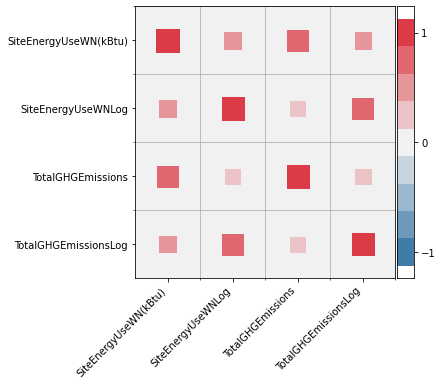

In [31]:
# Matrice de corrélation entre les targets
plt.figure(figsize=(5, 5))
df_target_corr = data_prepro[cols_target].corr()
outils_visu.corrplot(df_target_corr)

<span style='background:PowderBlue'>**Bilan - Algorithmes les plus performants**</span>

**Tableau de résultats des scores par modèle target transformée en log 10**

In [56]:
df_compar = df_comp_log.head(3)
df_compar

,Modèle,Fit time,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
20,gbr,0.22147,0.00265,0.71669,0.04637,0.11801,0.82283,0.00401,0.07404
18,etr,0.78122,0.01412,0.70708,0.04260,0.12084,1.00000,0.00000,-0.00000
19,cat,2.64042,0.07527,0.69965,0.04757,0.12501,0.93829,0.00231,0.02579


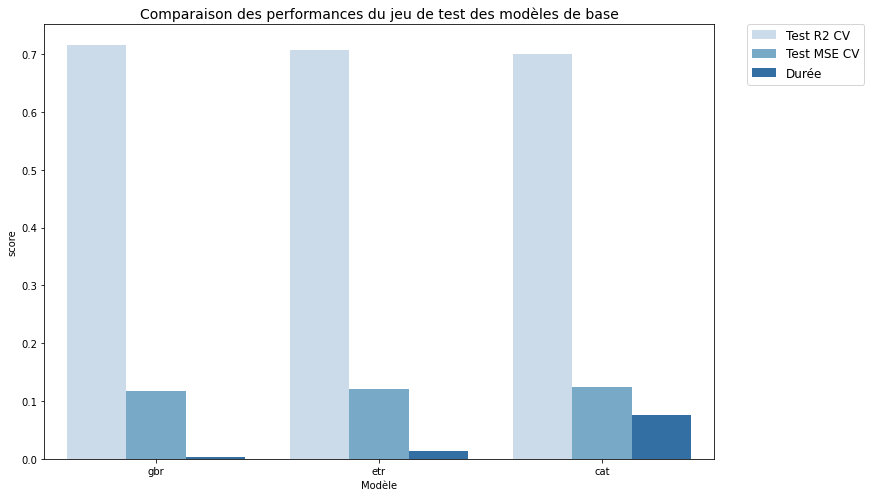

In [57]:
# Comparaison visuelle des 4 algorithmes les plus performants
comparaison_score_melt = pd.melt(df_compar, id_vars=[
                                 'Modèle'], value_name='score', value_vars=['Test R2 CV', 'Test MSE CV', 'Durée'])
# Visualisation
plt.figure(figsize=(12, 8))
sns.barplot(x=comparaison_score_melt['Modèle'],
            y=comparaison_score_melt['score'], hue=comparaison_score_melt['variable'], palette='Blues')
plt.title(
    'Comparaison des performances du jeu de test des modèles de base', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.show()

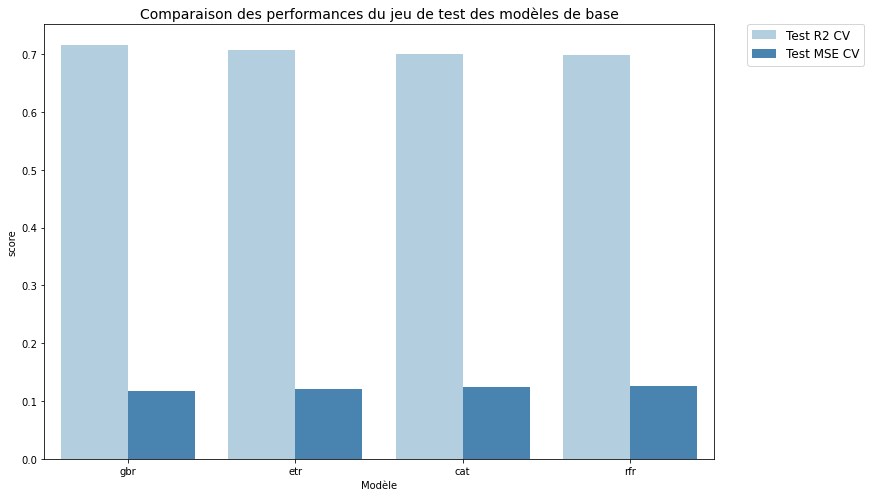

In [34]:
# Comparaison visuelle des 4 algorithmes les plus performants sans la durée
comparaison_score_melt = pd.melt(df_compar, id_vars=[
                                 'Modèle'], value_name='score', value_vars=['Test R2 CV', 'Test MSE CV'])
# Visualisation
plt.figure(figsize=(12, 8))
sns.barplot(x=comparaison_score_melt['Modèle'],
            y=comparaison_score_melt['score'], hue=comparaison_score_melt['variable'], palette='Blues')
plt.title(
    'Comparaison des performances du jeu de test des modèles de base', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.show()

**Bilan**:
*** 
- Les 3 modèles non optimisés **GradientBoostRegressor**, **CatBoostRegressor** et **ExtraTreesRegressor** ont de bonnes performances avec un léger avantage pour GradientBoostRegressor qui a un temps d'exécution légèrement inférieur.
- Nous utiliserons et optimiserons **GradientBoostRegressor** pour la suite de l'analyse.

## <span style='background:Thistle'>6. Optimisation de GradientBoostingRegressor</span>

Les paramètres globaux de ce modèle d'ensemble peuvent être divisés en 3 catégories :

- Paramètres spécifiques à l'arbre : Ils affectent chaque arbre individuel du modèle.
    - min_samples_split
    - min_samples_leaf
    - min_weight_fraction_leaf
    - max_depth
    - max_leaf_nodes
    - max_features
- Paramètres de boosting : Ils affectent l'opération de boosting dans le modèle.
    - learning_rate
    - n_estimators
    - subsample
- Paramètres divers : Autres paramètres pour le fonctionnement global.
     - loss
     - init
     - random_state
     - verbose
     - warm_start
     - presort 
     
 
 [Source](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)
 
 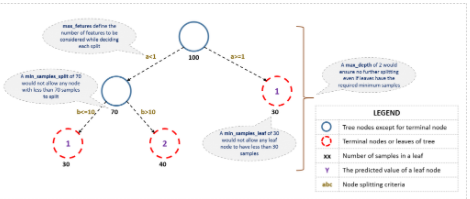

### <span style='background:PowderBlue'>6.1. Procédure itérative avec GridSearchCV</span>

Nous pouvons adopter l'approche suivante :

- Choisir un taux d'apprentissage relativement élevé. En général, la valeur par défaut de 0,1 fonctionne, mais une valeur comprise entre 0,05 et 0,2 devrait convenir pour différents problèmes.
- Déterminer le nombre optimal d'arbres pour ce taux d'apprentissage. Ce nombre devrait se situer entre 40 et 70. N'oubliez pas de choisir une valeur sur laquelle votre système peut travailler assez rapidement. En effet, elle sera utilisée pour tester différents scénarios et déterminer les paramètres de l'arbre.
- Régler les paramètres spécifiques à l'arbre pour le taux d'apprentissage décidé et le nombre d'arbres. Notez que nous pouvons choisir différents paramètres pour définir un arbre et je vais prendre un exemple ici.
- Réduire le taux d'apprentissage et augmenter proportionnellement les estimateurs pour obtenir des modèles plus robustes.

**Baseline**

In [35]:
# Modèle de base pour comparaison
param_grid0 = {'random_state': [seed]}
gbm0 = GradientBoostingRegressor()
outils_model.gbm_gridsearchcv_iterative(param_grid0, gbm0, X_train_log,
                                        y_train_log)


Best score : 0.7166874625965804 

avec les hyperparamètres :
{'random_state': 21}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 



**Réglage des paramètres spécifiques à l'arbre**

*Paramètres de démarrage fixé arbitrairement*

Afin de décider des paramètres de boosting, nous devons définir certaines valeurs initiales d'autres paramètres. Prenons les valeurs suivantes :

- min_samples_split = 17 : Cela devrait être ~0.5-1% des valeurs totales. Puisqu'il s'agit d'un problème avec des données déséquilibrées, nous prendrons une petite valeur dans l'intervalle.
- min_samples_leaf = 50 : Peut être choisi selon l'intuition. Ceci est juste utilisé pour éviter l'overfitting et encore une fois une petite valeur à cause des classes déséquilibrées.
- max_depth = None : Doit être choisi (4-10) en fonction du nombre d'observations et de prédicteurs. Recommandation pour régression : None
- max_features = None : C'est une règle générale pour commencer avec la régression.
- subsample = 0.8 : C'est une valeur de départ couramment utilisée.

**Réglage de n_estimators**

- **n_estimators** : le nombre d'arbres séquentiels à modéliser. Bien que GBM soit assez robuste pour un nombre plus élevé d'arbres, il peut toujours être surajusté à un moment donné. Par conséquent, ce nombre doit être ajusté en utilisant CV pour un taux d'apprentissage particulier.

In [36]:
param_grid1 = {'n_estimators': range(20, 81, 10)}
# Modèle de départ arbitraire
gbm1 = GradientBoostingRegressor(random_state=seed, learning_rate=0.1,
                                 min_samples_split=17, min_samples_leaf=20,
                                 max_depth=None, max_features=None,
                                 subsample=0.8)
outils_model.gbm_gridsearchcv_iterative(param_grid1, gbm1, X_train_log,
                                        y_train_log)


Best score : 0.688498950250196 

avec les hyperparamètres :
{'n_estimators': 40}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=20,
                          min_samples_split=17, min_weight_fraction_leaf=0.0,
                          n_estimators=40, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.8,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



- 40 est assez faible pour tenter de diminuer le learning-rate à 0.05 en doublant le n_estimator. 

In [37]:
param_grid1 = {'n_estimators': range(100, 200, 10)}
# Modèle de départ arbitraire
gbm1 = GradientBoostingRegressor(random_state=seed, learning_rate=0.05,
                                 min_samples_split=17, min_samples_leaf=20,
                                 max_depth=None, max_features=None,
                                 subsample=0.8)
outils_model.gbm_gridsearchcv_iterative(param_grid1, gbm1, X_train_log,
                                        y_train_log)


Best score : 0.6906805734887852 

avec les hyperparamètres :
{'n_estimators': 100}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=20,
                          min_samples_split=17, min_weight_fraction_leaf=0.0,
                          n_estimators=100, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.8,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



- **n_estimators** = 100
- **learning_rate**= 0.05

*Note* :
***
- **learning_rate** : Cela détermine l'impact de chaque arbre sur le résultat final. Le GBM fonctionne en commençant par une estimation initiale qui est mise à jour en utilisant la sortie de chaque arbre. Le paramètre d'apprentissage contrôle l'ampleur de ce changement dans les estimations.
Des valeurs faibles sont généralement préférées car elles rendent le modèle robuste aux caractéristiques spécifiques de l'arbre et lui permettent ainsi de bien se généraliser.
Des valeurs plus faibles nécessiteraient un plus grand nombre d'arbres pour modéliser toutes les relations et seraient coûteuses en termes de calcul.

**Réglage de max_depth et min_samples_split**

- **max_depth** : La profondeur maximale d'un arbre. Utilisé pour contrôler l'excès d'ajustement car une profondeur plus élevée permettra au modèle d'apprendre des relations très spécifiques à un échantillon particulier.
Doit être réglé à l'aide de CV.
- **min_samples_split** : Définit le nombre minimum d'échantillons (ou d'observations) requis dans un nœud pour être pris en compte pour le fractionnement. Utilisé pour contrôler le surajustement. Des valeurs plus élevées empêchent un modèle d'apprendre des relations qui pourraient être très spécifiques à l'échantillon particulier sélectionné pour un arbre. Des valeurs trop élevées peuvent entraîner un sous-ajustement, c'est pourquoi il convient de l'ajuster à l'aide de CV.

In [38]:
param_grid2 = {'max_depth': [range(5, 16, 1), None],
               'min_samples_split': range(1, 1001, 100)}
# Modèle de départ arbitraire
gbm2 = GradientBoostingRegressor(random_state=seed, learning_rate=0.05,
                                 n_estimators=70, max_features=None,
                                 subsample=0.8)
outils_model.gbm_gridsearchcv_iterative(param_grid2, gbm2, X_train_log,
                                        y_train_log)


Best score : 0.7075303246034601 

avec les hyperparamètres :
{'max_depth': None, 'min_samples_split': 101}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=101, min_weight_fraction_leaf=0.0,
                          n_estimators=70, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.8,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



- **max_depth** = None
- **min_samples_split**: 101

**Réglage de min_samples_leaf et min_samples_split**

- **min_samples_leaf** : Définit le minimum d'échantillons (ou d'observations) requis dans un noeud terminal ou une feuille. Utilisé pour contrôler l'over-fitting de manière similaire à min_samples_split. En général, des valeurs plus faibles doivent être choisies pour les problèmes de classes déséquilibrées car les régions dans lesquelles la classe minoritaire sera majoritaire seront très petites pour les problèmes de classification.

In [39]:
param_grid3 = {'min_samples_leaf': range(1, 71, 1)}
# Modèle de départ arbitraire
gbm3 = GradientBoostingRegressor(random_state=seed, learning_rate=0.05,
                                 n_estimators=70, max_depth=None,
                                 min_samples_split=101,
                                 max_features=None, subsample=0.8)
outils_model.gbm_gridsearchcv_iterative(param_grid3, gbm3, X_train_log,
                                        y_train_log)


Best score : 0.7075303246034601 

avec les hyperparamètres :
{'min_samples_leaf': 1}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=101, min_weight_fraction_leaf=0.0,
                          n_estimators=70, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.8,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



- **min_samples_leaf** = 1

**Réglage max_features**

- **max_features** : Le nombre de caractéristiques à prendre en compte lors de la recherche de la meilleure répartition. Elles seront sélectionnées aléatoirement. En règle générale, la racine carrée du nombre total de caractéristiques fonctionne bien, mais nous devrions vérifier jusqu'à 30-40% du nombre total de caractéristiques. Des valeurs plus élevées peuvent conduire à un ajustement excessif, mais cela dépend de chaque cas.

In [40]:
param_grid4 = {'max_features': [range(1, 20, 1), None, 'auto']}

# Modèle de départ arbitraire
gbm4 = GradientBoostingRegressor(random_state=seed, learning_rate=0.05,
                                 n_estimators=70, max_depth=7,
                                 min_samples_split=101,
                                 min_samples_leaf=1,
                                 subsample=0.8)
outils_model.gbm_gridsearchcv_iterative(param_grid4, gbm4, X_train_log,
                                        y_train_log)


Best score : 0.7109921249322252 

avec les hyperparamètres :
{'max_features': None}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=101,
                          min_weight_fraction_leaf=0.0, n_estimators=70,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=21, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 



- **max_features** = None

**Réglage de subsample**

- **subsample** : La fraction des observations à sélectionner pour chaque arbre. La sélection se fait par échantillonnage aléatoire.
Des valeurs légèrement inférieures à 1 rendent le modèle robuste en réduisant la variance.
Les valeurs typiques ~0.8 fonctionnent généralement bien mais peuvent être affinées davantage.

In [41]:
param_grid5 = {'subsample': [0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]}

# Modèle de départ arbitraire
gbm5 = GradientBoostingRegressor(random_state=seed, learning_rate=0.05,
                                 n_estimators=100, max_depth=7,
                                 min_samples_split=101,
                                 min_samples_leaf=1, max_features=None)
outils_model.gbm_gridsearchcv_iterative(param_grid5, gbm5, X_train_log,
                                        y_train_log)


Best score : 0.7166061536280046 

avec les hyperparamètres :
{'subsample': 0.6}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=101,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=21, subsample=0.6, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 



**Réglage learning_rate et n_estimators final**

In [42]:
param_grid5 = {'n_estimators': [1400]}

# Modèle de départ arbitraire
gbm5 = GradientBoostingRegressor(random_state=seed,
                                 learning_rate=0.005,
                                 #                                  n_estimators = 1400,
                                 max_depth=7,
                                 min_samples_split=101,
                                 subsample=0.65,
                                 min_samples_leaf=1,
                                 max_features=None)
outils_model.gbm_gridsearchcv_iterative(param_grid5, gbm5, X_train_log,
                                        y_train_log)


Best score : 0.7193514425495616 

avec les hyperparamètres :
{'n_estimators': 1400}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.005, loss='ls',
                          max_depth=7, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=101,
                          min_weight_fraction_leaf=0.0, n_estimators=1400,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=21, subsample=0.65, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 



**Modèle optimisé final**

In [43]:
# DataFrame sauvegardant les résultats pour les différents essais d'optimisation
df_resultats_gb = pd.DataFrame(dtype='object')

In [44]:
# Modèle optimisé après démarche itérative
gb_opt = GradientBoostingRegressor(random_state=seed,
                                   learning_rate=0.005,
                                   n_estimators=1400,
                                   max_depth=7,
                                   min_samples_split=101,
                                   subsample=0.65,
                                   min_samples_leaf=1,
                                   max_features=None)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_opt_man_sans_ess_total,0.74531,0.09244,0.30403,0.23057,0.23057,82.43947,4.55528,0.71935,0.04099,0.11665,0.86217,0.00213,0.05760


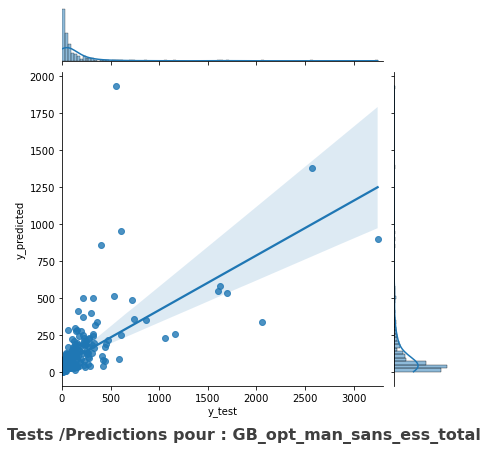

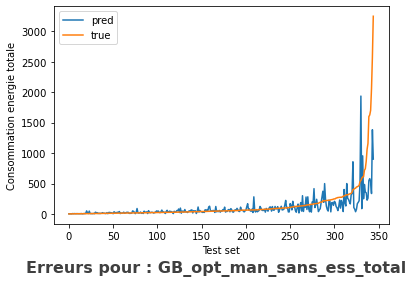

In [45]:
# Entraînement, scoring, prédictions et sauvegarde du modèle entraîné 
# avec la variable cible transformée en log10 + 1
df_resultats_gb, y_pred_gb_opt = outils_model.process_regression(gb_opt,
                                                                 X_train_log, X_test_log,
                                                                 y_train_log, y_test_log,
                                                                 df_resultats_gb,
                                                                 'GB_opt_man_sans_ess_total', xlim_sup=3300)

### <span style='background:PowderBlue'>6.2. RandomizedSearchCV - Recherche sur grille aléatoire avec validation croisée</span>

In [46]:
# Grille de paramètre
# Nombre d'arbres
n_estimators = range(1000, 2000, 100)
# Taux d'apprentissge
learning_rate = [0.001, 0.005, 0.01, 0.02, 0.03]
# Profondeur de l'arbre
max_depth = [5, 6, 7, 8, 9, 10]
# Nombre minimum d'échantillons requis pour chaque split de décision
min_samples_split = range(1, 200, 10)
# Nombre minimum d'échantillons requis pour chaque feuille
min_samples_leaf = [1, 2, 4]
# Sous-échantillon
subsample = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1]
# Grille de recherche
random_gb_grid = {'n_estimators': n_estimators,
                  'learning_rate': learning_rate,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'subsample': subsample}
# Instanciation du modèle
gb_rand = GradientBoostingRegressor(random_state=seed)

Grille de recherche : 

{'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.03],
 'max_depth': [5, 6, 7, 8, 9, 10],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': range(1, 200, 10),
 'n_estimators': range(1000, 2000, 100),
 'subsample': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1]}

Meilleurs hyperparamètres : 

{'learning_rate': 0.005,
 'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 31,
 'n_estimators': 1400,
 'subsample': 0.9}

Performance du modèle :

Average Error: 0.2334 degrees.
Accuracy = 81.91%.
mae=0.2333611625639247
mse=0.09384681425298905
rmse=0.3063442740659421
r2=0.7414241497958033


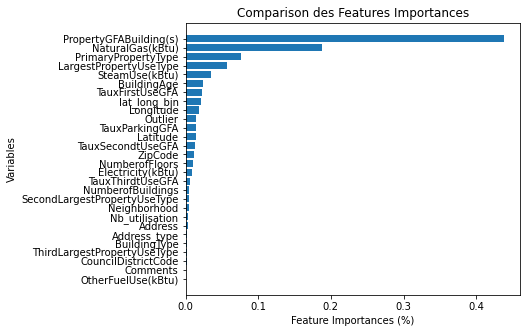

In [47]:
best_gb_random = outils_model.gradientboostingregressor_randomizedsearchcv_paramgrid(
    random_gb_grid, gb_rand, X_train_log, y_train_log, X_test_log, y_test_log)

In [48]:
# Modèle optimisé après randomized search cv
gb_rand = GradientBoostingRegressor(random_state=seed,
                                    learning_rate=0.005,
                                    n_estimators=1400,
                                    max_depth=6,
                                    min_samples_split=31,
                                    subsample=0.9,
                                    min_samples_leaf=1,
                                    max_features=None)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_opt_man_sans_ess_total,0.74531,0.09244,0.30403,0.23057,0.23057,82.43947,4.55528,0.71935,0.04099,0.11665,0.86217,0.00213,0.05760
GB_opt_rand,0.74111,0.09396,0.30653,0.23364,0.23364,81.87573,8.30886,0.71682,0.04107,0.11761,0.90655,0.00163,0.03905


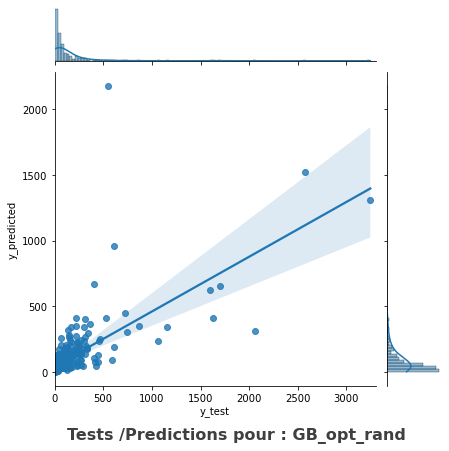

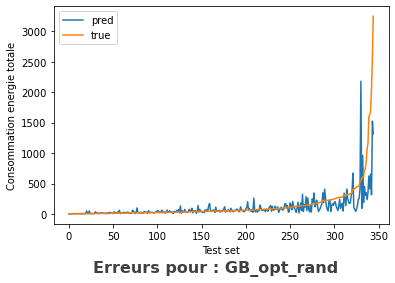

In [49]:
# Entraînement, scoring, prédictions et sauvegarde du modèle entraîné 
# avec la variable cible transformée en log10 + 1
df_resultats_gb, y_pred_gb_rand = outils_model.process_regression(gb_rand,
                                                                  X_train_log, X_test_log,
                                                                  y_train_log, y_test_log,
                                                                  df_resultats_gb,
                                                                  'GB_opt_rand', xlim_sup=3300)

### <span style='background:PowderBlue'>6.3. Hyperopt de sklearn</span>

**Création de l'objective function à optimiser**

In [50]:
def objective_function_regression(estimator):
    mse_array = cross_val_score(
        estimator, X_train, y_train, cv=3, n_jobs=-1, scoring=make_scorer(mse))
    return np.mean(mse_array)

**Définir l'espace de recherche à partir duquel on échantillonne les paramètres et l'estimateur**

In [179]:
# hyperopt object for
# scope.define(GradientBoostingRegressor)

# search space
n_estimators = hp.randint('n_estimators', 2000)
learning_rate = hp.loguniform('learning_rate', -3, 1)
max_depth = hp.randint('max_depth', 10)
max_features = hp.randint('max_features', X.shape[1]-1)
min_samples_leaf = hp.randint('min_samples_leaf', 10)
min_samples_split = hp.randint('min_samples_split', 200)
# subsample = hp.uniform('subsample', 0, 1)

# model / estimator to be optimized
est0 = (0.1, scope.GradientBoostingRegressor(n_estimators=n_estimators + 1,
                                             learning_rate=learning_rate,
                                             max_depth=max_depth + 1,
                                             max_features=max_features + 1,
                                             min_samples_leaf=min_samples_leaf + 1,
                                             min_samples_split=min_samples_split + 1,
                                             #subsample=subsample,
                                             random_state=21)
        )

# search space
search_space_regression = hp.pchoice('estimator', [est0])

**Effectuer l'optimisation**

In [180]:
best = fmin(
    fn=objective_function_regression,
    space=search_space_regression,
    # This is the optimization algorithm hyperopt uses, a tree of parzen estimators
    algo=tpe.suggest,
    max_evals=100,
    verbose=2  # The number of iterations
)

print(best)

100%|██████████| 100/100 [02:46<00:00,  1.67s/trial, best loss: 318354.56598969206]
{'estimator': 0, 'learning_rate': 0.05011093156720587, 'max_depth': 9, 'max_features': 22, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 1861}


**Attribuer les paramètres optimisés et les appliquer au jeu de données**

In [182]:
# allocate
regressor = GradientBoostingRegressor(learning_rate=best['learning_rate'],
                                      max_depth=best['max_depth'],
                                      max_features=best['max_features'],
                                      min_samples_leaf=best['min_samples_leaf'],
                                      n_estimators=best['n_estimators'],
                                      min_samples_split=best['min_samples_split'],
                                      #subsample=best['subsample'],
                                      random_state=21
                                      )
# fit
regressor.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05011093156720587,
                          loss='ls', max_depth=9, max_features=22,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=5,
                          min_samples_split=20, min_weight_fraction_leaf=0.0,
                          n_estimators=1861, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [184]:
df_resultats_gb[['Modèle','R2','MSE','RMSE','MAE','Durée']]

,Modèle,R2,MSE,RMSE,MAE,Durée
0,GB_opt_man_sans_ess_total,0.74531,0.09244,0.30403,0.23057,4.55528
1,GB_opt_rand,0.74111,0.09396,0.30653,0.23364,8.30886
2,GB_opt_hyperopt,0.69395,0.11108,0.33328,0.25847,0.49783
3,GB_opt_man_avec_ess,0.80009,0.06834,0.26143,0.19720,0.60037
4,GB_opt_man_sans_ess_reduit,0.74292,0.08789,0.29646,0.23019,5.31093
5,GB_opt_hyperopt,0.66842,0.12034,0.34690,0.26548,2.47070
6,GB_opt_hyperopt,0.62260,0.13697,0.37010,0.28288,1.82094
7,GB_opt_hyperopt,0.54906,0.16366,0.40455,0.31767,0.91580
8,GB_opt_hyperopt,0.62649,0.13556,0.36819,0.28621,0.46675
9,GB_opt_hyperopt,0.69866,0.10937,0.33071,0.24899,9.49525


Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_opt_man_sans_ess_total,0.74531,0.09244,0.30403,0.23057,0.23057,82.43947,4.55528,0.71935,0.04099,0.11665,0.86217,0.00213,0.05760
GB_opt_rand,0.74111,0.09396,0.30653,0.23364,0.23364,81.87573,8.30886,0.71682,0.04107,0.11761,0.90655,0.00163,0.03905
GB_opt_hyperopt,0.69395,0.11108,0.33328,0.25847,0.25847,80.54459,0.49783,0.64734,0.04492,0.14650,0.93248,0.00261,0.02822
GB_opt_man_avec_ess,0.80009,0.06834,0.26143,0.19720,0.19720,86.32559,0.60037,0.81856,0.04471,0.06962,0.95030,0.00182,0.01979
GB_opt_man_sans_ess_reduit,0.74292,0.08789,0.29646,0.23019,0.23019,83.52972,5.31093,0.77000,0.06009,0.08842,0.92954,0.00203,0.02807
GB_opt_hyperopt,0.66842,0.12034,0.34690,0.26548,0.26548,79.80469,2.47070,0.64657,0.05140,0.14677,0.99937,0.00009,0.00026
GB_opt_hyperopt,0.62260,0.13697,0.37010,0.28288,0.28288,77.05264,1.82094,0.62707,0.05069,0.15437,0.99996,0.00001,0.00002
GB_opt_hyperopt,0.54906,0.16366,0.40455,0.31767,0.31767,75.49025,0.91580,0.47894,0.05528,0.21570,0.98594,0.00085,0.00588
GB_opt_hyperopt,0.62649,0.13556,0.36819,0.28621,0.28621,77.97278,0.46675,0.62638,0.04737,0.15522,0.86363,0.00369,0.05700
GB_opt_hyperopt,0.69866,0.10937,0.33071,0.24899,0.24899,81.22156,9.49525,0.67154,0.03911,0.13641,0.99999,0.00000,0.00000


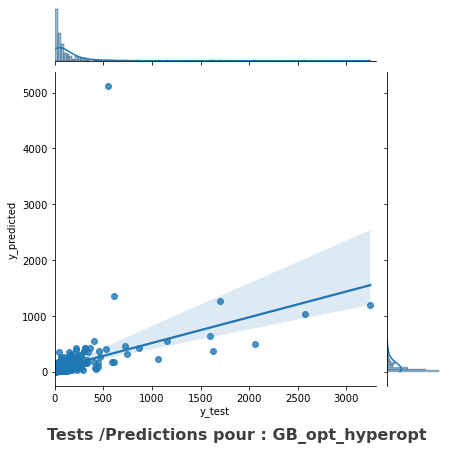

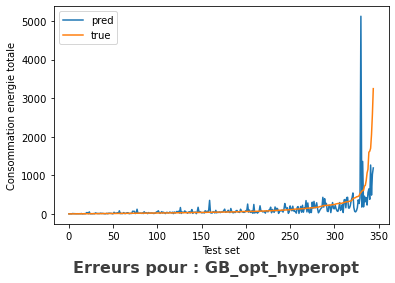

In [183]:
# Evaluation du modèle
df_resultats_gb, y_pred_gb_hyperopt = outils_model.process_regression(regressor,
                                                                      X_train_log, X_test_log,
                                                                      y_train_log, y_test_log,
                                                                      df_resultats_gb,
                                                                      'GB_opt_hyperopt', xlim_sup=3300)

<span style='background:PaleGreen'>**Feature importance**</span>

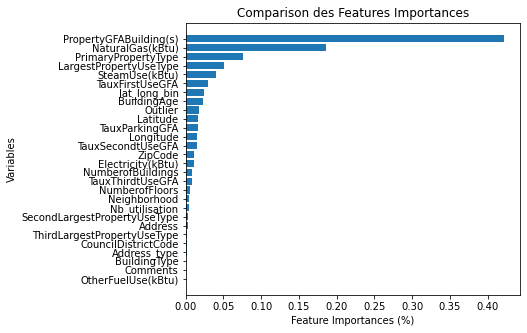

In [65]:
# Calcul de l'importance de chaque variables
feature_gb_importance = gb_opt.feature_importances_
sorted_idx = feature_gb_importance.argsort()
feature_gb_importance_tri = outils_data.sort_array(feature_gb_importance)
# Visualisation des features importance
outils_model.plot_features_importance(
    feature_gb_importance_tri, X_train_log.columns[sorted_idx])

<span style='background:PaleGreen'>**Shape values**</span>

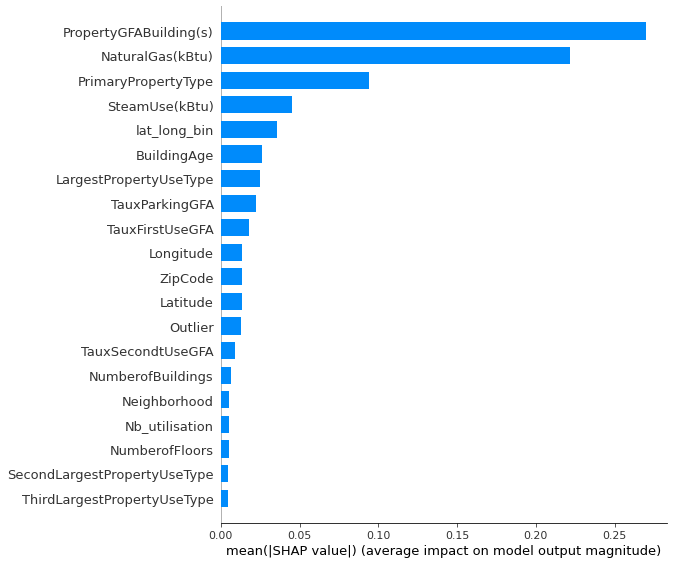

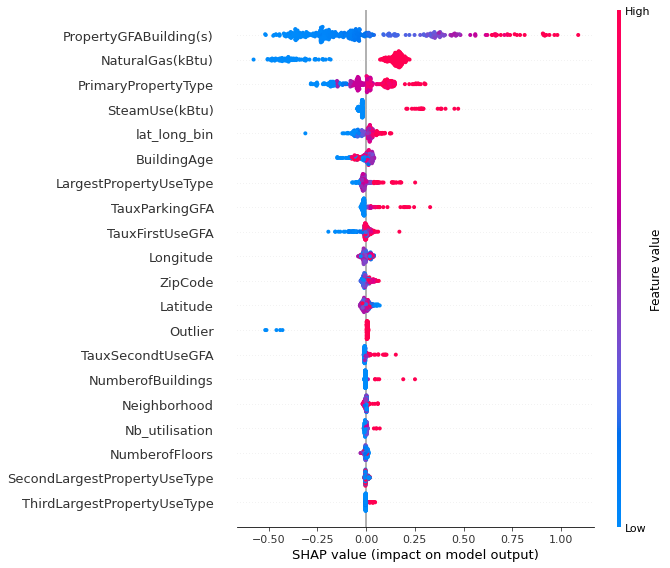

In [66]:
outils_model.plot_shape_values(gb_opt, X_test_log)

<span style='background:PaleGreen'>**Permutation importance avec sklearn**</span>

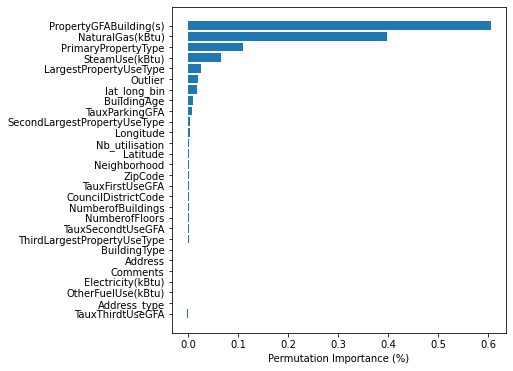

In [67]:
outils_model.plot_permutation_importance(gb_opt, X_test_log, y_test_log)

<span style='background:PaleGreen'>**Permutation importance avec eli5**</span>

In [68]:
# calculer l'importance des features avec librairie eli5
outils_model.plot_permutation_importance_eli5(gb_opt, X_test_log, y_test_log)

Weight,Feature
0.5817 ± 0.0685,PropertyGFABuilding(s)
0.3677 ± 0.0580,NaturalGas(kBtu)
0.1024 ± 0.0224,PrimaryPropertyType
0.0493 ± 0.0154,SteamUse(kBtu)
0.0259 ± 0.0113,LargestPropertyUseType
0.0225 ± 0.0101,Outlier
0.0180 ± 0.0041,lat_long_bin
0.0128 ± 0.0047,BuildingAge
0.0078 ± 0.0082,TauxParkingGFA
0.0035 ± 0.0012,SecondLargestPropertyUseType


<span style='background:PaleGreen'>**Sélection itérative de variables - RFE**</span>

In [69]:
# Dataframe de comparaion des modèles entraînés sur jeu réduit
df_resultats_rfe = pd.DataFrame(dtype='object')

In [70]:
# Modèle ExtraTreesRegressor optimisé entraîné sur jeu réduit
gb_optimise_rfe = GradientBoostingRegressor(random_state=21)

gb_optimise_red = GradientBoostingRegressor(random_state=seed,
                                            learning_rate=0.005,
                                            n_estimators=1400,
                                            max_depth=7,
                                            min_samples_split=101,
                                            subsample=0.65,
                                            min_samples_leaf=1,
                                            max_features=None)

Variable(s) hautement corrélée(s) à supprimer :

{'LargestPropertyUseType'}

Le nombre optimal de variables est : 20

Les variables sélectionnées sont:
['PrimaryPropertyType',
 'SecondLargestPropertyUseType',
 'Outlier',
 'Address',
 'ZipCode',
 'lat_long_bin',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'Latitude',
 'Longitude',
 'Nb_utilisation',
 'TauxParkingGFA',
 'TauxFirstUseGFA',
 'TauxSecondtUseGFA',
 'TauxThirdtUseGFA',
 'BuildingAge']


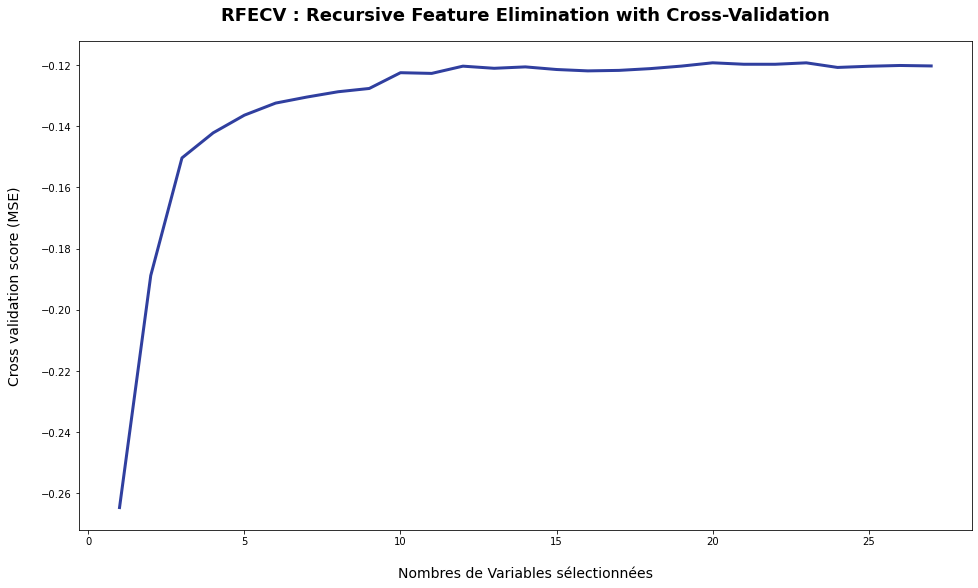


Les variables non indispensables :

Index(['BuildingType', 'CouncilDistrictCode', 'Neighborhood', 'ThirdLargestPropertyUseType',
       'Comments', 'Address_type', 'OtherFuelUse(kBtu)'],
      dtype='object')


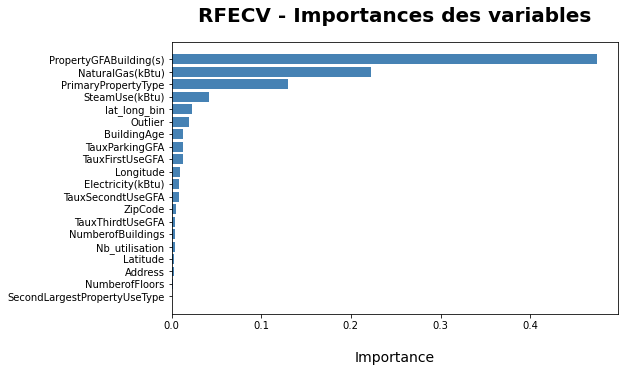

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_optimise_rfe,0.73921,0.09465,0.30765,0.23355,0.23355,82.34085,5.59040,0.71925,0.04242,0.11675,0.85988,0.00260,0.05856


In [71]:
df_resultats_rfe, y_pred_gb_opt_rfe, gb_optimise_rfe = outils_model.calcul_plot_rfecv(
    gb_optimise_rfe, gb_optimise_red, 'GB_optimise_rfe',
    X_train_log, X_test_log, y_train_log, y_test_log,  df_resultats_rfe)

<span style='background:PaleGreen'>**Learning curve**</span>

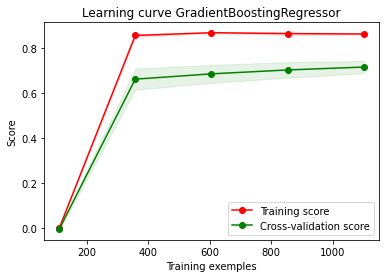

In [72]:
outils_model.plot_learning_curve(gb_opt, 'Learning curve GradientBoostingRegressor',
                                 X_train_log, y_train_log)

**Bilan** :
***
- Pas d'over-fitting.
- Plus de données doivent être fournies au modèle.

### <span style='background:PowderBlue'>6.4. Modèle optimisé final</span>

In [20]:
%%time 

# Instanciation du modèle optimisé
gb_best = GradientBoostingRegressor(learning_rate=0.005,
                                    n_estimators=1400,
                                    max_depth=7,
                                    min_samples_split=101,
                                    subsample=0.65,
                                    min_samples_leaf=1,
                                    max_features=None)

# Entraînement du modèle
gb_best.fit(X_train_log, y_train_log)

# Sauvegarde du modèle de régression entaîné
with open('modeles/modele_ges_optimise_final' + titre + '.pickle', 'wb') as f:
    pickle.dump(gb_best, f, pickle.HIGHEST_PROTOCOL)
        

Wall time: 4.43 s


GradientBoostingRegressor(learning_rate=0.005, max_depth=7,
                          min_samples_split=101, n_estimators=1400,
                          subsample=0.65)

### <span style='background:PowderBlue'>6.5.  Erreurs de prédictions</span>

In [227]:
# Predictions avec le train set
y_train_pred = gb_best.predict(X_train_log)

# Prédictions avec le test set
y_test_pred = gb_best.predict(X_test_log)

# DataFrame du jeu de test
df_error_test = pd.DataFrame({'y_test_pred': y_test_pred,
                              'y_test_log': y_test_log})
df_error_test['erreur_abs'] = abs(y_test_pred - y_test_log)
df_error_test['erreur_sens'] = y_test_pred - y_test_log

# DataFrame du jeu d'entraînement
df_error_train = pd.DataFrame({'y_train_pred': y_train_pred,
                               'y_train_log': y_train_log})
df_error_train['erreur_abs'] = abs(y_train_pred - y_train_log)
df_error_train['erreur_sens'] = y_train_pred - y_train_log

**Bâtiment avec une erreur sur le jeu de test de plus de 95%**

In [228]:
# erreur sur le jeu de test de plus de 95%
df_erreur_sup95 = df_error_test[df_error_test['erreur_abs']
                                > df_error_test['erreur_abs'].quantile(0.95)]

In [232]:
df_erreur_sup95=df_erreur_sup95.sort_values(by=['erreur_abs','erreur_sens'], ascending=[False, False])
df_erreur_sup95

,y_test_pred,y_test_log,erreur_abs,erreur_sens
954,1.57763,2.62680,1.04918,-1.04918
720,1.70396,0.76118,0.94278,0.94278
1201,1.71497,0.78462,0.93035,0.93035
1575,1.20124,2.11083,0.90959,-0.90959
344,1.88873,2.76950,0.88076,-0.88076
1657,1.62515,2.46474,0.83959,-0.83959
688,1.54777,2.36758,0.81981,-0.81981
211,2.52917,3.31320,0.78402,-0.78402
1614,1.90159,2.64634,0.74476,-0.74476
1719,1.63977,2.35129,0.71153,-0.71153


In [230]:
df_sup95 = data_prepro.iloc[df_erreur_sup95.index.to_list(), :]
df_sup95.describe(include='all');

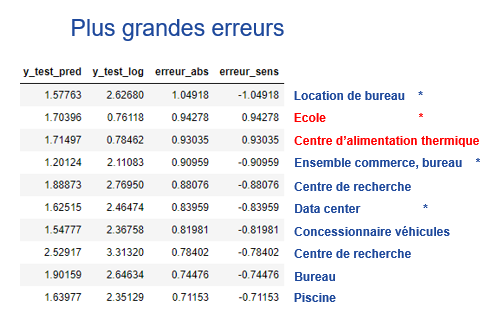

**Visualisation des valeurs réelles versus valeurs prédites test/train**

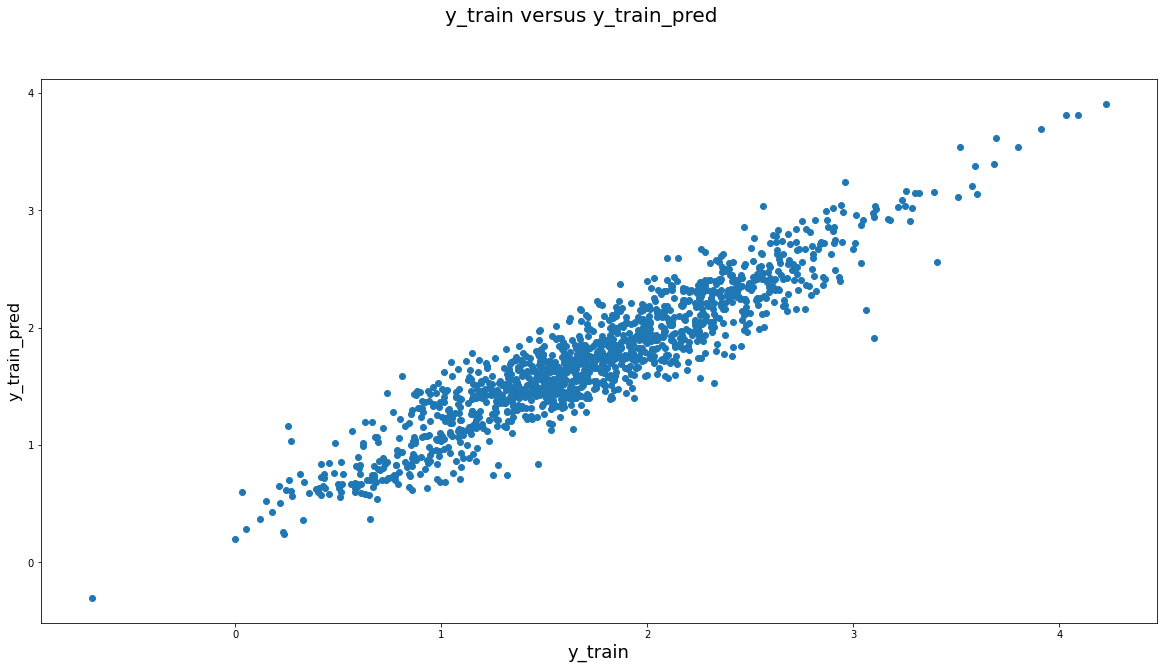

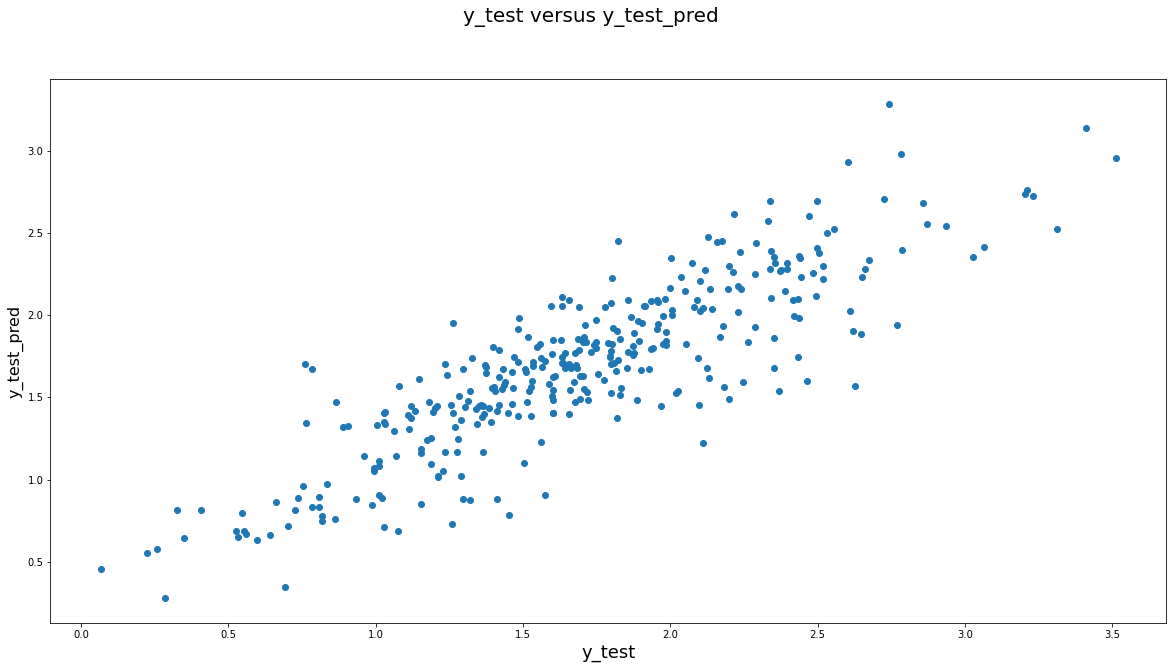

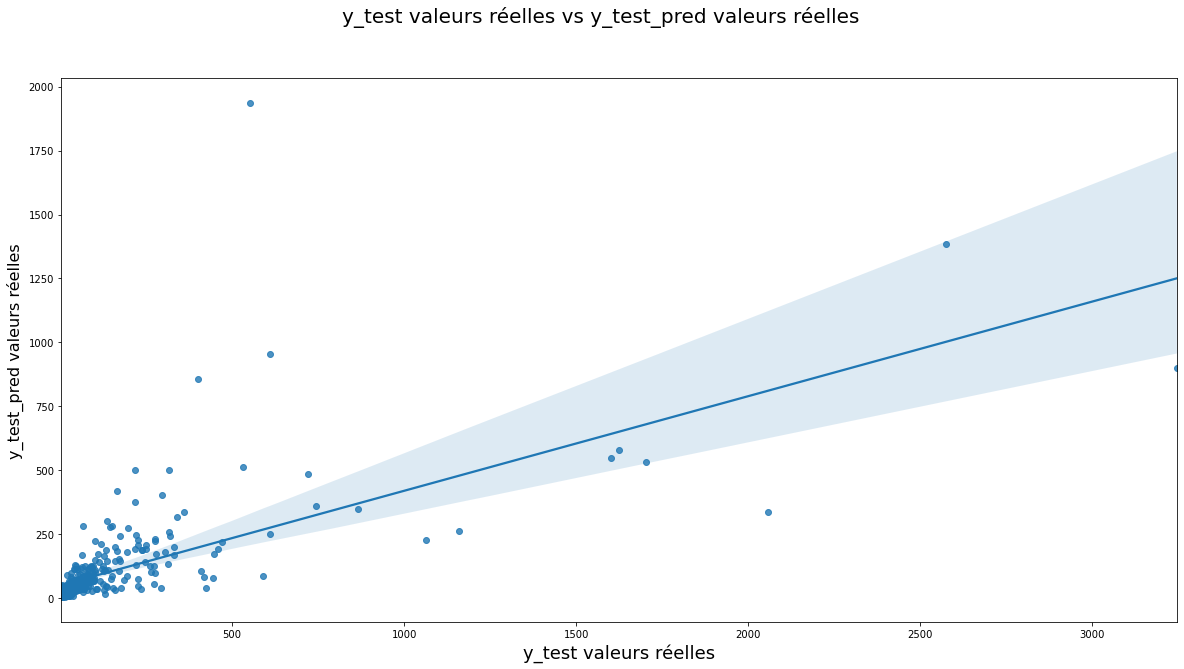

In [77]:
# Visualisation des prédictions / valeurs réélles du jeu d'entraînement
fig = plt.figure(figsize=(20, 10))
plt.scatter(y_train_log, y_train_pred)
fig.suptitle('y_train versus y_train_pred', fontsize=20)
plt.xlabel('y_train', fontsize=18)
plt.ylabel('y_train_pred', fontsize=16)

# Visualisation des prédictions / valeurs réélles du jeu de test en log
fig = plt.figure(figsize=(20, 10))
plt.scatter(y_test_log, y_test_pred)
fig.suptitle('y_test versus y_test_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_test_pred', fontsize=16)


# Visualisation des prédictions / valeurs réélles du jeu de test non transformé en log
fig = plt.figure(figsize=(20, 10))
sns.regplot((10**y_test_log)+1, (10**y_test_pred)+1)
fig.suptitle('y_test valeurs réelles vs y_test_pred valeurs réelles',
             fontsize=20)         # Plot heading
plt.xlabel('y_test valeurs réelles', fontsize=18)
plt.ylabel('y_test_pred valeurs réelles', fontsize=16)
plt.show()

**Bilan** :
- Les plus grosses erreurs ne touchent pas le même type de bâtiment (ex : data center, bureau, école, centres de stockage...), pas forcément selon la surface, le nombre d'étage... pas le même style d'énergie (fuel...), difficile donc d'analyser les erreurs.     

## <span style='background:Thistle'>7. Intérêt de l'EnergyStar Score sur la prédiction des émissions de gaz à effet de serre</span>

### <span style='background:PowderBlue'>7.1. Prédictions des émissions de gaz à effet de serre AVEC ENERGY STAR SCORE</span>

#### <span style='background:PeachPuff'>7.1.1. Préparation des données</span>

In [78]:
# Copie du jeu de données
data_ess = data.copy()

In [79]:
# Suppression des valeurs manquantes de la variables ENERGYSTARScore
data_ess.dropna(axis=0, inplace=True)

In [80]:
# Variables qualitatives
cols_cat_ess = data_ess.select_dtypes(exclude=[np.number]).columns.to_list()
cols_cat_ess

['BuildingType',
 'CouncilDistrictCode',
 'Neighborhood',
 'PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'Outlier',
 'Comments',
 'Address',
 'ZipCode',
 'lat_long_bin',
 'Address_type']

In [81]:
# Variables quantitatives
cols_num_ess = data_ess.select_dtypes(include=[np.number]).columns.to_list()
# Suppression des variables cibles
del cols_num_ess[0:4]
cols_num_ess

['ENERGYSTARScore',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'OtherFuelUse(kBtu)',
 'Latitude',
 'Longitude',
 'Nb_utilisation',
 'TauxParkingGFA',
 'TauxFirstUseGFA',
 'TauxSecondtUseGFA',
 'TauxThirdtUseGFA',
 'BuildingAge']

In [82]:
# Matrice X
X_ess = data_ess[cols_cat_ess+cols_num_ess]
X_ess.shape

(1142, 29)

In [83]:
# Analyse de la target 'TotalGHGEmissions' non transformée
y_ess = data_ess['TotalGHGEmissions']
y_ess.shape

(1142,)

In [84]:
# Analyse de la target 'TotalGHGEmissionsLog' en log 10
y_ess_log = data_ess['TotalGHGEmissionsLog']
y_ess_log.shape

(1142,)

In [85]:
# Découpage du jeu de données en train set et test set
# Target 'TotalGHGEmissions' non transformée
X_train_ess, X_test_ess, y_train_ess, y_test_ess = train_test_split(
    X_ess, y_ess, test_size=0.2, random_state=seed)
print(f'X_train : {X_train_ess.shape} - X_test : {X_test_ess.shape}')
print(f'y_train : {y_train_ess.shape} - y_test : {y_test_ess.shape}')
# Target 'TotalGHGEmissionsLog' en log 10
X_train_ess_log, X_test_ess_log, y_train_ess_log, y_test_ess_log = train_test_split(
    X_ess, y_ess_log, test_size=0.2, random_state=seed)
print(
    f'X_train_log : {X_train_ess_log.shape} - X_test : {X_test_ess_log.shape}')
print(
    f'y_train_log : {y_train_ess_log.shape} - y_test : {y_test_ess_log.shape}')

X_train : (913, 29) - X_test : (229, 29)
y_train : (913,) - y_test : (229,)
X_train_log : (913, 29) - X_test : (229, 29)
y_train_log : (913,) - y_test : (229,)


In [86]:
# Utilisation de TargetEncoder()
target_encoder_ess = TargetEncoder()
# Target 'TotalGHGEmissions' non transformée
X_train_ess[cols_cat_ess] = target_encoder_ess.fit_transform(
    X_train_ess[cols_cat_ess], y_train_ess)
X_test_ess[cols_cat_ess] = target_encoder_ess.transform(
    X_test_ess[cols_cat_ess])

# Sauvegarde de l'encoder
with open('modeles/encoder_target_ges_ess.pickle', 'wb') as f:
    pickle.dump(target_encoder_ess, f, pickle.HIGHEST_PROTOCOL)

In [87]:
# Target 'TotalGHGEmissionsLog' en log 10
target_encoder_ess = TargetEncoder()
X_train_ess_log[cols_cat_ess] = target_encoder_ess.fit_transform(
    X_train_ess_log[cols_cat_ess], y_train_ess_log)
X_test_ess_log[cols_cat_ess] = target_encoder_ess.transform(
    X_test_ess_log[cols_cat_ess])

# Sauvegarde de l'encoder
with open('modeles/encoder_target_ges_ess_log10.pickle', 'wb') as f:
    pickle.dump(target_encoder_ess, f, pickle.HIGHEST_PROTOCOL)

In [88]:
# RobustScaler
scaler_rob_ess = RobustScaler()
# Target 'TotalGHGEmissions' non transformée
X_train_ess[cols_num_ess] = scaler_rob_ess.fit_transform(
    X_train_ess[cols_num_ess].copy(deep=True))
X_test_ess[cols_num_ess] = scaler_rob_ess.transform(
    X_test_ess[cols_num_ess].copy(deep=True))

# Sauvegarde de la standardisation
with open('modeles/standardisation_robust_ges.pickle', 'wb') as f:
    pickle.dump(scaler_rob_ess, f, pickle.HIGHEST_PROTOCOL)

In [89]:
# Target 'TotalGHGEmissionsLog' en log 10
scaler_rob_ess = RobustScaler()
X_train_ess_log[cols_num_ess] = scaler_rob_ess.fit_transform(
    X_train_ess_log[cols_num_ess].copy(deep=True))
X_test_ess_log[cols_num_ess] = scaler_rob_ess.transform(
    X_test_ess_log[cols_num_ess].copy(deep=True))

# Sauvegarde de la standardisation
with open('modeles/standardisation_robust_ges_log10.pickle', 'wb') as f:
    pickle.dump(scaler_rob_ess, f, pickle.HIGHEST_PROTOCOL)

#### <span style='background:PeachPuff'>7.1.2. Modélisation avec GradientBoostingRegressor</span>

In [90]:
# Target 'TotalGHGEmissions' non transformée
df_comp_ess = outils_model.comparer_baseline_regressors(
    X_train_ess, y_train_ess)
df_comp_ess.style.hide_index()

Exécution terminée - Modèle : dum_mean
Exécution terminée - Modèle : dum_med
Exécution terminée - Modèle : lin
Exécution terminée - Modèle : ridge
Exécution terminée - Modèle : lasso
Exécution terminée - Modèle : en
Exécution terminée - Modèle : svr
Exécution terminée - Modèle : br
Exécution terminée - Modèle : hr
Exécution terminée - Modèle : omp
Exécution terminée - Modèle : lars
Exécution terminée - Modèle : knr
Exécution terminée - Modèle : dt
Exécution terminée - Modèle : ada
Exécution terminée - Modèle : xgb
Exécution terminée - Modèle : sgd
Exécution terminée - Modèle : lgbm
Exécution terminée - Modèle : rfr
Exécution terminée - Modèle : etr
Exécution terminée - Modèle : cat
Exécution terminée - Modèle : gbr
Exécution terminée - Modèle : bag


Modèle,Fit time,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
cat,1.59893,0.00352,0.54857,0.21080,388757.80909,0.99888,0.00029,696.25981
etr,0.53128,0.01451,0.47909,0.31791,395376.01877,1.00000,0.00000,-0.00000
gbr,0.21894,0.00469,0.38689,0.41108,486189.43757,0.99338,0.00139,4146.03039
rfr,0.76530,0.01102,0.33582,0.46090,428391.65474,0.89707,0.02119,67879.63829
bag,0.08772,0.00468,0.26859,0.37463,452405.29613,0.88421,0.02979,75669.12366
lgbm,0.09717,0.00220,0.07526,1.01663,416436.36912,0.71013,0.04387,189001.29822
hr,0.04608,0.00199,0.00528,0.29184,596949.18182,0.09520,0.03310,585530.22831
svr,0.04701,0.00620,-0.05398,0.04341,658535.98777,-0.01871,0.00192,656471.86216
dum_mean,0.00040,0.00100,-0.08199,0.13269,647590.76777,0.00000,0.00000,644540.70312
dum_med,0.00080,0.00070,-0.08747,0.06250,664773.03379,-0.02894,0.00378,662884.21562


In [91]:
# Target 'TotalGHGEmissionsLog' en log 10
df_comp_log_ess = outils_model.comparer_baseline_regressors(
    X_train_ess_log, y_train_ess_log)
df_comp_log_ess.style.hide_index()

Exécution terminée - Modèle : dum_mean
Exécution terminée - Modèle : dum_med
Exécution terminée - Modèle : lin
Exécution terminée - Modèle : ridge
Exécution terminée - Modèle : lasso
Exécution terminée - Modèle : en
Exécution terminée - Modèle : svr
Exécution terminée - Modèle : br
Exécution terminée - Modèle : hr
Exécution terminée - Modèle : omp
Exécution terminée - Modèle : lars
Exécution terminée - Modèle : knr
Exécution terminée - Modèle : dt
Exécution terminée - Modèle : ada
Exécution terminée - Modèle : xgb
Exécution terminée - Modèle : sgd
Exécution terminée - Modèle : lgbm
Exécution terminée - Modèle : rfr
Exécution terminée - Modèle : etr
Exécution terminée - Modèle : cat
Exécution terminée - Modèle : gbr
Exécution terminée - Modèle : bag


Modèle,Fit time,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
gbr,0.21141,0.00156,0.80476,0.05227,0.07462,0.91429,0.00231,0.03414
cat,1.54194,0.00378,0.80297,0.05264,0.07520,0.97931,0.00164,0.00824
etr,0.45001,0.01224,0.77714,0.06319,0.08524,1.00000,0.00000,-0.00000
xgb,0.13503,0.00391,0.77351,0.06856,0.08579,0.99938,0.00012,0.00025
lgbm,0.07947,0.00321,0.77188,0.07724,0.08650,0.97782,0.00143,0.00883
rfr,0.62349,0.01004,0.77011,0.07814,0.08719,0.96934,0.00150,0.01221
bag,0.07391,0.00000,0.75171,0.08431,0.09413,0.95745,0.00328,0.01694
svr,0.04480,0.00469,0.73896,0.05148,0.10160,0.81247,0.00543,0.07471
ada,0.13226,0.00781,0.68896,0.07087,0.12005,0.76826,0.01074,0.09231
br,0.00534,0.00156,0.66269,0.06370,0.13171,0.70706,0.00773,0.11672


- GradientBoostRegressor est toujours le modèle le plus performant.

**Ajout d'une nouvelle variable ==> re-réglage du modèle**

In [92]:
# Modèle de base pour comparaison
ess_param_grid0 = {'random_state': [seed]}
ess_gbm0 = GradientBoostingRegressor()
outils_model.gbm_gridsearchcv_iterative(ess_param_grid0, ess_gbm0,
                                        X_train_ess_log, y_train_ess_log)


Best score : 0.8047574647974296 

avec les hyperparamètres :
{'random_state': 21}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 



In [93]:
ess_param_grid1 = {'n_estimators': range(20, 81, 10)}
# Modèle de départ arbitraire
ess_gbm1 = GradientBoostingRegressor(random_state=seed,
                                     learning_rate=0.1,
                                     min_samples_split=17,
                                     min_samples_leaf=20,
                                     max_depth=None,
                                     max_features=None,
                                     subsample=0.8)
outils_model.gbm_gridsearchcv_iterative(ess_param_grid1, ess_gbm1,
                                        X_train_ess_log, y_train_ess_log)


Best score : 0.7839880807561528 

avec les hyperparamètres :
{'n_estimators': 50}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=20,
                          min_samples_split=17, min_weight_fraction_leaf=0.0,
                          n_estimators=50, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.8,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



- 50 est assez faible pour tenter de diminuer le learning-rate à 0.05 en doublant le n_estimator. 

In [94]:
ess_param_grid2 = {'n_estimators': range(100, 200, 10)}
ess_gbm2 = GradientBoostingRegressor(random_state=seed,
                                     learning_rate=0.05,
                                     min_samples_split=17,
                                     min_samples_leaf=20,
                                     max_depth=None,
                                     max_features=None,
                                     subsample=0.8)
outils_model.gbm_gridsearchcv_iterative(ess_param_grid2, ess_gbm2,
                                        X_train_ess_log, y_train_ess_log)


Best score : 0.7857871293488652 

avec les hyperparamètres :
{'n_estimators': 120}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=20,
                          min_samples_split=17, min_weight_fraction_leaf=0.0,
                          n_estimators=120, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.8,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



In [95]:
ess_param_grid3 = {'max_depth': [range(5, 16, 1), None],
                   'min_samples_split': range(1, 1001, 100)}
ess_gbm3 = GradientBoostingRegressor(random_state=seed,
                                     learning_rate=0.05,
                                     n_estimators=110,
                                     max_features=None,
                                     subsample=0.8)
outils_model.gbm_gridsearchcv_iterative(ess_param_grid3, ess_gbm3,
                                        X_train_ess_log, y_train_ess_log)


Best score : 0.8190522258150912 

avec les hyperparamètres :
{'max_depth': None, 'min_samples_split': 101}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=101, min_weight_fraction_leaf=0.0,
                          n_estimators=110, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.8,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



In [96]:
ess_param_grid4 = {'min_samples_leaf': range(1, 71, 1)}
ess_gbm4 = GradientBoostingRegressor(random_state=seed,
                                     learning_rate=0.05,
                                     n_estimators=110,
                                     max_depth=None,
                                     min_samples_split=101,
                                     max_features=None,
                                     subsample=0.8)
outils_model.gbm_gridsearchcv_iterative(ess_param_grid4, ess_gbm4, X_train_ess_log,
                                        y_train_ess_log)


Best score : 0.8190522258150912 

avec les hyperparamètres :
{'min_samples_leaf': 1}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=101, min_weight_fraction_leaf=0.0,
                          n_estimators=110, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.8,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



In [97]:
ess_param_grid5 = {'max_features': [range(1, 20, 1), None, 'auto']}
ess_gbm5 = GradientBoostingRegressor(random_state=seed,
                                     learning_rate=0.05,
                                     n_estimators=110,
                                     max_depth=None,
                                     min_samples_split=101,
                                     min_samples_leaf=1,
                                     subsample=0.8)
outils_model.gbm_gridsearchcv_iterative(ess_param_grid5, ess_gbm5,
                                        X_train_ess_log, y_train_ess_log)


Best score : 0.8190522258150912 

avec les hyperparamètres :
{'max_features': None}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=101, min_weight_fraction_leaf=0.0,
                          n_estimators=110, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.8,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



In [98]:
ess_param_grid6 = {'subsample': [0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]}
ess_gbm6 = GradientBoostingRegressor(random_state=seed,
                                     learning_rate=0.05,
                                     n_estimators=110,
                                     max_depth=None,
                                     max_features=None,
                                     min_samples_split=101,
                                     min_samples_leaf=1)
outils_model.gbm_gridsearchcv_iterative(ess_param_grid6, ess_gbm6,
                                        X_train_ess_log, y_train_ess_log)


Best score : 0.8190522258150912 

avec les hyperparamètres :
{'subsample': 0.8}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=101, min_weight_fraction_leaf=0.0,
                          n_estimators=110, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.8,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



In [99]:
ess_param_grid7 = {'n_estimators': range(1000, 2000, 100)}
ess_gbm7 = GradientBoostingRegressor(random_state=seed,
                                     learning_rate=0.005,
                                     max_depth=None,
                                     max_features=None,
                                     min_samples_split=101,
                                     min_samples_leaf=1,
                                     subsample=0.9)
outils_model.gbm_gridsearchcv_iterative(ess_param_grid7, ess_gbm7,
                                        X_train_ess_log, y_train_ess_log)


Best score : 0.8165737059629745 

avec les hyperparamètres :
{'n_estimators': 1300}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.005, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=101, min_weight_fraction_leaf=0.0,
                          n_estimators=1300, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.9,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



**Modèle optimisé**

In [100]:
ess_gb_opt = GradientBoostingRegressor(random_state=seed,
                                       learning_rate=0.05,
                                       n_estimators=110,
                                       max_depth=None,
                                       max_features=None,
                                       min_samples_split=101,
                                       min_samples_leaf=1,
                                       subsample=0.9)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_opt_man_sans_ess_total,0.74531,0.09244,0.30403,0.23057,0.23057,82.43947,4.55528,0.71935,0.04099,0.11665,0.86217,0.00213,0.05760
GB_opt_rand,0.74111,0.09396,0.30653,0.23364,0.23364,81.87573,8.30886,0.71682,0.04107,0.11761,0.90655,0.00163,0.03905
GB_opt_hyperopt,0.69395,0.11108,0.33328,0.25847,0.25847,80.54459,0.49783,0.64734,0.04492,0.14650,0.93248,0.00261,0.02822
GB_opt_man_avec_ess,0.80009,0.06834,0.26143,0.19720,0.19720,86.32559,0.60037,0.81856,0.04471,0.06962,0.95030,0.00182,0.01979


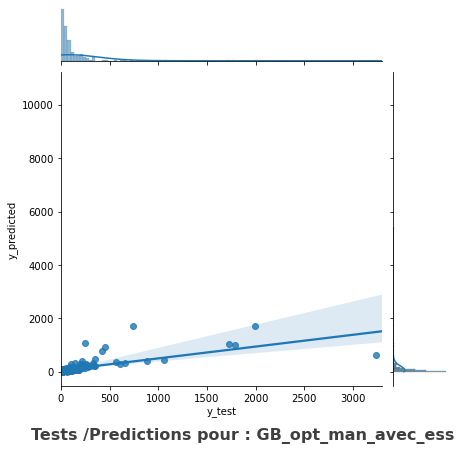

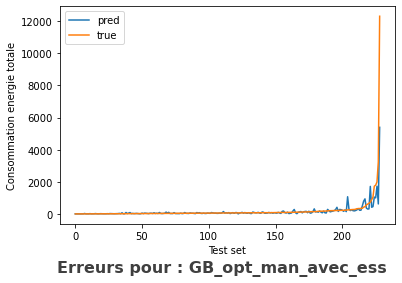

In [101]:
df_resultats_gb, y_pred_gb_opt_ess = outils_model.process_regression(ess_gb_opt,
                                                                     X_train_ess_log, X_test_ess_log,
                                                                     y_train_ess_log, y_test_ess_log,
                                                                     df_resultats_gb,
                                                                     'GB_opt_man_avec_ess', xlim_sup=3300)

**Learning curve**

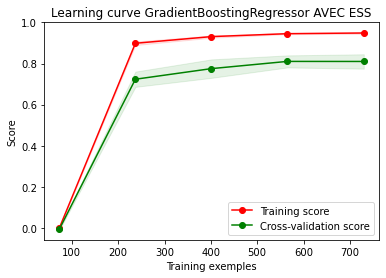

In [102]:
outils_model.plot_learning_curve(ess_gb_opt, 'Learning curve GradientBoostingRegressor AVEC ESS',
                                 X_train_ess_log, y_train_ess_log)

**Bilan** :
***
- Pas d'over-fitting.
- Plus de données doivent être fournies au modèle.

**Features importance**

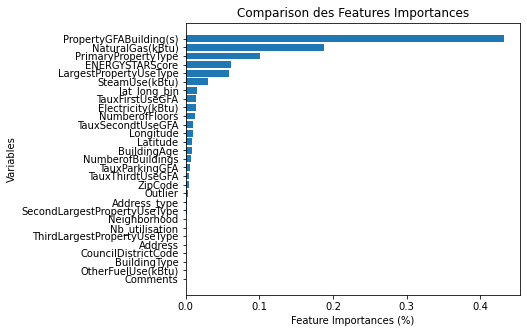

In [252]:
# Calcul de l'importance de chaque variables
feature_gb_avec_ess_importance = ess_gb_opt.feature_importances_
sorted_idx = feature_gb_avec_ess_importance.argsort()
feature_gb_avec_ess_importance_tri = outils_data.sort_array(feature_gb_avec_ess_importance)
# Visualisation des features importance
outils_model.plot_features_importance(
    feature_gb_avec_ess_importance_tri, X_train_ess_log.columns[sorted_idx])

**Permutation importance avec eli5**

In [253]:
# calculer l'importance des features avec librairie eli5
outils_model.plot_permutation_importance_eli5(
    ess_gb_opt, X_test_ess_log, y_test_ess_log)

Weight,Feature
0.7121 ± 0.0654,PropertyGFABuilding(s)
0.2851 ± 0.0835,NaturalGas(kBtu)
0.2118 ± 0.0326,PrimaryPropertyType
0.1291 ± 0.0302,ENERGYSTARScore
0.0868 ± 0.0183,LargestPropertyUseType
0.0357 ± 0.0134,SteamUse(kBtu)
0.0094 ± 0.0052,Outlier
0.0062 ± 0.0063,NumberofBuildings
0.0050 ± 0.0038,BuildingAge
0.0031 ± 0.0025,ZipCode


**Sélection itérative de variables - RFE**

In [247]:
# Dataframe de comparaion des modèles entraînés sur jeu réduit
df_resultats_rfe = pd.DataFrame(dtype='object')

In [254]:
# Modèle GradientBoostRegressor 
gb_optimise_rfe_avec_ess = GradientBoostingRegressor(random_state=21)

Variable(s) hautement corrélée(s) à supprimer :

{'LargestPropertyUseType'}

Le nombre optimal de variables est : 14

Les variables sélectionnées sont:
['PrimaryPropertyType',
 'lat_long_bin',
 'ENERGYSTARScore',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'Latitude',
 'Longitude',
 'TauxParkingGFA',
 'TauxFirstUseGFA',
 'TauxSecondtUseGFA',
 'BuildingAge']


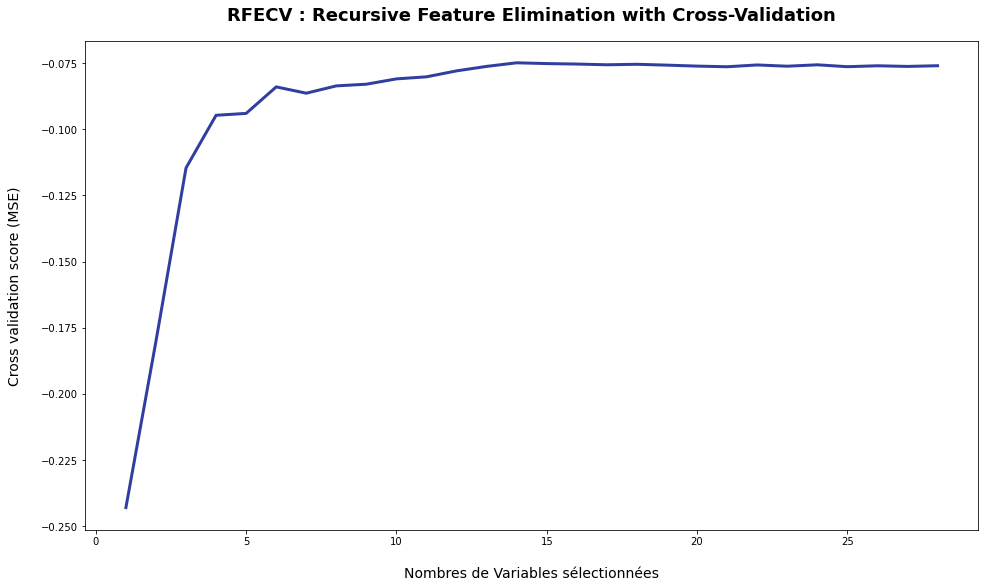


Les variables non indispensables :

Index(['BuildingType', 'CouncilDistrictCode', 'Neighborhood', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'Outlier', 'Comments', 'Address', 'ZipCode', 'Address_type',
       'NumberofBuildings', 'OtherFuelUse(kBtu)', 'Nb_utilisation', 'TauxThirdtUseGFA'],
      dtype='object')


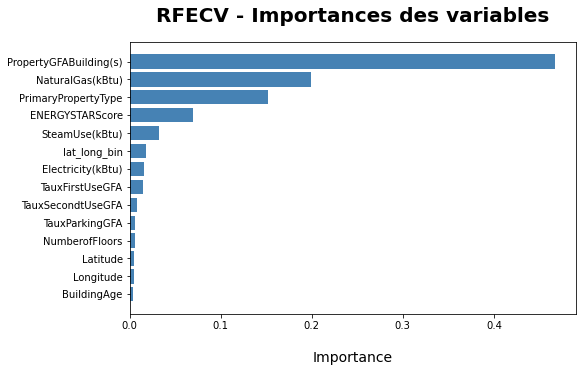

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_optimise_rfe,0.73357,0.09108,0.30180,0.23484,0.23484,83.12273,3.03608,0.76498,0.06246,0.09028,0.92625,0.00215,0.02938
GB_optimise_rfe,0.74055,0.08870,0.29782,0.23297,0.23297,83.26603,3.67573,0.76358,0.06469,0.09070,0.92652,0.00232,0.02927
GB_optimise_rfe_avec_ess,0.78914,0.07209,0.26849,0.20185,0.20185,85.72165,0.34151,0.80565,0.05555,0.07403,0.94515,0.00224,0.02185


In [255]:
df_resultats_rfe, y_pred_gb_optimise, gb_optimise_rfe = outils_model.calcul_plot_rfecv(
    gb_optimise_rfe_avec_ess, ess_gb_opt, 'GB_optimise_rfe_avec_ess',
    X_train_ess_log, X_test_ess_log, 
    y_train_ess_log, y_test_ess_log,  df_resultats_rfe)

**Bilan :**
***
La variable **ENERGYSTARScore** est la quatrième variable le plus importante pour RFECV, feature importance et compte pour 13% dans la performance du modèle. A ce stade, on peut penser que cette variable aura un impact sur la performance du modèle.

### <span style='background:PowderBlue'>7.2. Prédictions des émissions de gaz à effet de serre SANS ENERGY STAR SCORE</span>

En utilisant le même jeu de données très réduit (environ 36% de valeurs manquantes pour les 1722 bâtiments du jeu de données nettoyé déjà pauvre en données)

#### <span style='background:PeachPuff'>7.2.1. Préparation des données</span>

In [103]:
# Copie du jeu de données
data_sans_ess = data.copy()

In [104]:
# Suppression des valeurs manquantes de la variables ENERGYSTARScore
# (seules valeurs manquantes de notre jeu de donnée)
data_sans_ess.dropna(axis=0, inplace=True)
# Suppression de la variable ENERGYSTARScore du dataframe à modéliser
data_sans_ess.drop('ENERGYSTARScore', axis=1, inplace=True)

In [105]:
# Variables qualitatives
cols_cat_sans_ess = data_sans_ess.select_dtypes(
    exclude=[np.number]).columns.to_list()
cols_cat_sans_ess

['BuildingType',
 'CouncilDistrictCode',
 'Neighborhood',
 'PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'Outlier',
 'Comments',
 'Address',
 'ZipCode',
 'lat_long_bin',
 'Address_type']

In [106]:
# Variables quantitatives
cols_num_sans_ess = data_sans_ess.select_dtypes(
    include=[np.number]).columns.to_list()
# Suppression des variables cibles
del cols_num_sans_ess[0:4]
cols_num_sans_ess

['NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'OtherFuelUse(kBtu)',
 'Latitude',
 'Longitude',
 'Nb_utilisation',
 'TauxParkingGFA',
 'TauxFirstUseGFA',
 'TauxSecondtUseGFA',
 'TauxThirdtUseGFA',
 'BuildingAge']

In [107]:
# Matrice X
X_sans_ess = data_sans_ess[cols_cat_sans_ess+cols_num_sans_ess]
X_sans_ess.shape

(1142, 28)

In [108]:
# Analyse de la target 'TotalGHGEmissionsLog' en log 10
y_sans_ess_log = data_sans_ess['TotalGHGEmissionsLog']
y_sans_ess_log.shape

(1142,)

In [109]:
# Target 'TotalGHGEmissionsLog' en log 10
X_train_sans_ess_log, X_test_sans_ess_log, y_train_sans_ess_log, y_test_sans_ess_log = train_test_split(
    X_sans_ess, y_sans_ess_log, test_size=0.2, random_state=seed)
print(
    f'X_train_sans_ess_log : {X_train_sans_ess_log.shape} - X_test_sans_ess_log : {X_test_sans_ess_log.shape}')
print(
    f'y_train_sans_ess_log : {y_train_sans_ess_log.shape} - y_test_sans_ess_log : {y_test_sans_ess_log.shape}')

X_train_sans_ess_log : (913, 28) - X_test_sans_ess_log : (229, 28)
y_train_sans_ess_log : (913,) - y_test_sans_ess_log : (229,)


In [110]:
# Utilisation de TargetEncoder()
target_encoder_sans_ess = TargetEncoder()
# Target 'TotalGHGEmissionsLog' en log 10
X_train_sans_ess_log[cols_cat_sans_ess] = target_encoder_sans_ess.fit_transform(
    X_train_sans_ess_log[cols_cat_sans_ess], y_train_sans_ess_log)
X_test_sans_ess_log[cols_cat_sans_ess] = target_encoder_sans_ess.transform(
    X_test_sans_ess_log[cols_cat_sans_ess])

In [111]:
# Sauvegarde de l'encoder
with open('modeles/encoder_target_ges_sans_ess.pickle', 'wb') as f:
    pickle.dump(target_encoder_sans_ess, f, pickle.HIGHEST_PROTOCOL)

In [112]:
# RobustScaler
scaler_rob_sans_ess = RobustScaler()
# Target 'TotalGHGEmissionsLog' en log 10
X_train_sans_ess_log[cols_num_sans_ess] = scaler_rob_sans_ess.fit_transform(
    X_train_sans_ess_log[cols_num_sans_ess].copy(deep=True))
X_test_sans_ess_log[cols_num_sans_ess] = scaler_rob_sans_ess.transform(
    X_test_sans_ess_log[cols_num_sans_ess].copy(deep=True))

In [113]:
# Sauvegarde de la standardisation
with open('modeles/standardisation_robust_sans_ges.pickle', 'wb') as f:
    pickle.dump(scaler_rob_sans_ess, f, pickle.HIGHEST_PROTOCOL)

#### <span style='background:PeachPuff'>7.2.2. Modélisation avec GradientBoostingRegressor</span>

**Jeu de données réduit ==> re-réglage du modèle**

In [114]:
# Modèle de base pour comparaison
sans_ess_param_grid0 = {'random_state': [seed]}
sans_ess_gbm0 = GradientBoostingRegressor()
outils_model.gbm_gridsearchcv_iterative(sans_ess_param_grid0, sans_ess_gbm0,
                                        X_train_sans_ess_log, y_train_sans_ess_log)


Best score : 0.7588042434027471 

avec les hyperparamètres :
{'random_state': 21}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 



In [115]:
sans_ess_param_grid1 = {'n_estimators': range(20, 81, 10)}
# Modèle de départ arbitraire
sans_ess_gbm1 = GradientBoostingRegressor(random_state=seed,
                                          learning_rate=0.1,
                                          min_samples_split=17,
                                          min_samples_leaf=20,
                                          max_depth=None,
                                          max_features=None,
                                          subsample=0.8)
outils_model.gbm_gridsearchcv_iterative(sans_ess_param_grid1, sans_ess_gbm1,
                                        X_train_sans_ess_log, y_train_sans_ess_log)


Best score : 0.7409276565659932 

avec les hyperparamètres :
{'n_estimators': 50}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=20,
                          min_samples_split=17, min_weight_fraction_leaf=0.0,
                          n_estimators=50, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.8,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



- 40 est assez faible pour tenter de diminuer le learning-rate à 0.05 en doublant le n_estimator. 

In [116]:
sans_ess_param_grid2 = {'n_estimators': range(100, 200, 10)}
sans_ess_gbm2 = GradientBoostingRegressor(random_state=seed,
                                          learning_rate=0.05,
                                          min_samples_split=17,
                                          min_samples_leaf=20,
                                          max_depth=None,
                                          max_features=None,
                                          subsample=0.8)
outils_model.gbm_gridsearchcv_iterative(sans_ess_param_grid2, sans_ess_gbm2,
                                        X_train_sans_ess_log, y_train_sans_ess_log)


Best score : 0.7420184310645427 

avec les hyperparamètres :
{'n_estimators': 100}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=20,
                          min_samples_split=17, min_weight_fraction_leaf=0.0,
                          n_estimators=100, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.8,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



In [117]:
sans_ess_param_grid3 = {'max_depth': [range(5, 16, 1), None],
                        'min_samples_split': range(1, 1001, 100)}
sans_ess_gbm3 = GradientBoostingRegressor(random_state=seed,
                                          learning_rate=0.05,
                                          n_estimators=110,
                                          max_features=None,
                                          subsample=0.8)
outils_model.gbm_gridsearchcv_iterative(sans_ess_param_grid3, sans_ess_gbm3,
                                        X_train_sans_ess_log, y_train_sans_ess_log)


Best score : 0.7679610292694583 

avec les hyperparamètres :
{'max_depth': None, 'min_samples_split': 101}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=101, min_weight_fraction_leaf=0.0,
                          n_estimators=110, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.8,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



In [118]:
sans_ess_param_grid4 = {'min_samples_leaf': range(1, 71, 1)}
sans_ess_gbm4 = GradientBoostingRegressor(random_state=seed,
                                          learning_rate=0.05,
                                          n_estimators=110,
                                          max_depth=None,
                                          min_samples_split=101,
                                          max_features=None,
                                          subsample=0.8)
outils_model.gbm_gridsearchcv_iterative(sans_ess_param_grid4, sans_ess_gbm4,
                                        X_train_sans_ess_log, y_train_sans_ess_log)


Best score : 0.7679610292694583 

avec les hyperparamètres :
{'min_samples_leaf': 1}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=101, min_weight_fraction_leaf=0.0,
                          n_estimators=110, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.8,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



In [119]:
sans_ess_param_grid5 = {'max_features': [range(1, 20, 1), None, 'auto']}
sans_ess_gbm5 = GradientBoostingRegressor(random_state=seed,
                                          learning_rate=0.05,
                                          n_estimators=110,
                                          max_depth=None,
                                          min_samples_split=101,
                                          min_samples_leaf=1,
                                          subsample=0.8)
outils_model.gbm_gridsearchcv_iterative(sans_ess_param_grid5, sans_ess_gbm5,
                                        X_train_sans_ess_log, y_train_sans_ess_log)


Best score : 0.7679610292694583 

avec les hyperparamètres :
{'max_features': None}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=101, min_weight_fraction_leaf=0.0,
                          n_estimators=110, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.8,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



In [120]:
sans_ess_param_grid6 = {'subsample': [
    0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]}
sans_ess_gbm6 = GradientBoostingRegressor(random_state=seed,
                                          learning_rate=0.05,
                                          n_estimators=110,
                                          max_depth=None,
                                          max_features=None,
                                          min_samples_split=101,
                                          min_samples_leaf=1)
outils_model.gbm_gridsearchcv_iterative(sans_ess_param_grid6, sans_ess_gbm6,
                                        X_train_sans_ess_log, y_train_sans_ess_log)


Best score : 0.7679610292694583 

avec les hyperparamètres :
{'subsample': 0.8}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=101, min_weight_fraction_leaf=0.0,
                          n_estimators=110, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.8,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



In [121]:
sans_ess_param_grid6 = {'n_estimators': range(1000, 2000, 100)}
sans_ess_gbm6 = GradientBoostingRegressor(random_state=seed,
                                          learning_rate=0.005,
                                          max_depth=None,
                                          max_features=None,
                                          min_samples_split=101,
                                          min_samples_leaf=1,
                                          subsample=0.75)
outils_model.gbm_gridsearchcv_iterative(sans_ess_param_grid6, sans_ess_gbm6,
                                        X_train_sans_ess_log, y_train_sans_ess_log)


Best score : 0.769998955799825 

avec les hyperparamètres :
{'n_estimators': 1200}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.005, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=101, min_weight_fraction_leaf=0.0,
                          n_estimators=1200, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.75,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



In [122]:
sans_ess_param_grid7 = {'subsample': [
    0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]}
sans_ess_gbm7 = GradientBoostingRegressor(random_state=seed,
                                          learning_rate=0.005,
                                          n_estimators=1200,
                                          max_depth=None,
                                          max_features=None,
                                          min_samples_split=101,
                                          min_samples_leaf=1)
outils_model.gbm_gridsearchcv_iterative(sans_ess_param_grid7, sans_ess_gbm7,
                                        X_train_sans_ess_log, y_train_sans_ess_log)


Best score : 0.769998955799825 

avec les hyperparamètres :
{'subsample': 0.75}

Modèle : GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.005, loss='ls',
                          max_depth=None, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=101, min_weight_fraction_leaf=0.0,
                          n_estimators=1200, n_iter_no_change=None,
                          presort='deprecated', random_state=21, subsample=0.75,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False) 



**Modèle optimisé**

In [123]:
# Instanciation du modèle
sans_ess_gb_opt = GradientBoostingRegressor(random_state=seed,
                                            learning_rate=0.005,
                                            n_estimators=1200,
                                            max_depth=None,
                                            max_features=None,
                                            min_samples_split=101,
                                            min_samples_leaf=1,
                                            subsample=0.75)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_opt_man_sans_ess_total,0.74531,0.09244,0.30403,0.23057,0.23057,82.43947,4.55528,0.71935,0.04099,0.11665,0.86217,0.00213,0.05760
GB_opt_rand,0.74111,0.09396,0.30653,0.23364,0.23364,81.87573,8.30886,0.71682,0.04107,0.11761,0.90655,0.00163,0.03905
GB_opt_hyperopt,0.69395,0.11108,0.33328,0.25847,0.25847,80.54459,0.49783,0.64734,0.04492,0.14650,0.93248,0.00261,0.02822
GB_opt_man_avec_ess,0.80009,0.06834,0.26143,0.19720,0.19720,86.32559,0.60037,0.81856,0.04471,0.06962,0.95030,0.00182,0.01979
GB_opt_man_sans_ess_reduit,0.74292,0.08789,0.29646,0.23019,0.23019,83.52972,5.31093,0.77000,0.06009,0.08842,0.92954,0.00203,0.02807


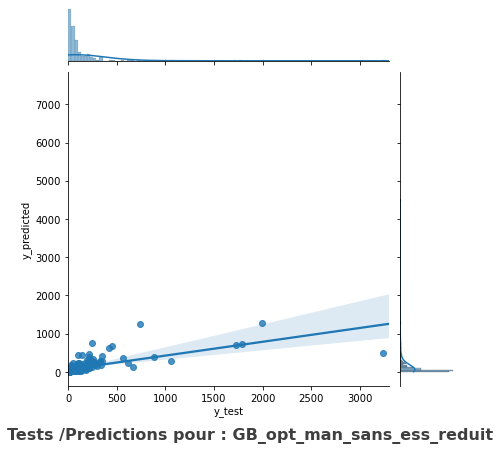

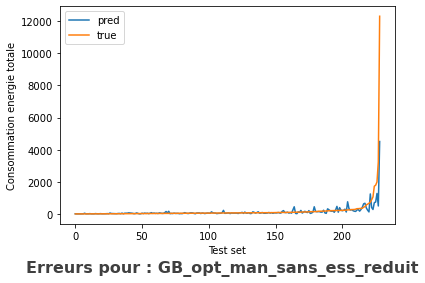

In [124]:
# Entraînement, scoring, prédictions et sauvegarde du modèle entraîné 
# avec la variable cible transformée en log10 + 1
df_resultats_gb, y_pred_gb_opt_sans_ess = outils_model.process_regression(sans_ess_gb_opt,
                                                                          X_train_sans_ess_log, X_test_sans_ess_log,
                                                                          y_train_sans_ess_log, y_test_sans_ess_log,
                                                                          df_resultats_gb,
                                                                          'GB_opt_man_sans_ess_reduit', xlim_sup=3300)

In [241]:
df_resultats_gb.iloc[[3,4], :][['Modèle','R2','MSE','RMSE','MAE','Durée']]

,Modèle,R2,MSE,RMSE,MAE,Durée
3,GB_opt_man_avec_ess,0.80009,0.06834,0.26143,0.19720,0.60037
4,GB_opt_man_sans_ess_reduit,0.74292,0.08789,0.29646,0.23019,5.31093


**Learning curve**

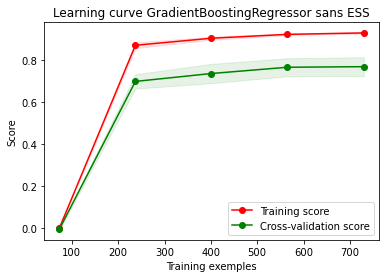

In [125]:
outils_model.plot_learning_curve(sans_ess_gb_opt, 'Learning curve GradientBoostingRegressor sans ESS',
                                 X_train_sans_ess_log, y_train_sans_ess_log)

**Bilan** :
***
- Pas d'over-fitting.
- Plus de données doivent être fournies au modèle.

**Features importance**

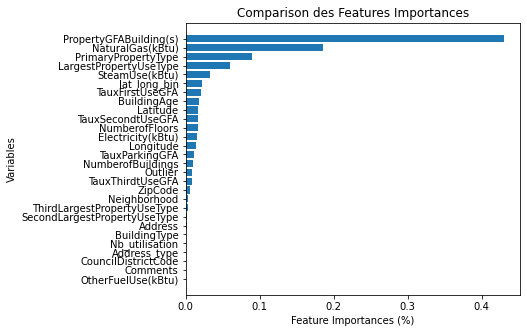

In [244]:
# Calcul de l'importance de chaque variables
feature_gb_sans_ess_importance = sans_ess_gb_opt.feature_importances_
sorted_idx = feature_gb_sans_ess_importance.argsort()
feature_gb_sans_ess_importance_tri = outils_data.sort_array(feature_gb_sans_ess_importance)
# Visualisation des features importance
outils_model.plot_features_importance(
    feature_gb_sans_ess_importance_tri, X_train_sans_ess_log.columns[sorted_idx])

**Permutation importance avec eli5**

In [245]:
# calculer l'importance des features avec librairie eli5
outils_model.plot_permutation_importance_eli5(
    sans_ess_gb_opt, X_test_sans_ess_log, y_test_sans_ess_log)

Weight,Feature
0.6576 ± 0.1222,PropertyGFABuilding(s)
0.2771 ± 0.0878,NaturalGas(kBtu)
0.2112 ± 0.0585,PrimaryPropertyType
0.0841 ± 0.0209,LargestPropertyUseType
0.0392 ± 0.0159,Outlier
0.0298 ± 0.0138,SteamUse(kBtu)
0.0113 ± 0.0043,BuildingAge
0.0084 ± 0.0078,NumberofBuildings
0.0067 ± 0.0040,TauxParkingGFA
0.0037 ± 0.0048,Longitude


**Sélection itérative de variables - RFE**

In [250]:
# Modèle GradientBoostRegressor 
gb_optimise_rfe = GradientBoostingRegressor(random_state=21)

Variable(s) hautement corrélée(s) à supprimer :

{'LargestPropertyUseType'}

Le nombre optimal de variables est : 26

Les variables sélectionnées sont:
['BuildingType',
 'CouncilDistrictCode',
 'Neighborhood',
 'PrimaryPropertyType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'Outlier',
 'Address',
 'ZipCode',
 'lat_long_bin',
 'Address_type',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'OtherFuelUse(kBtu)',
 'Latitude',
 'Longitude',
 'Nb_utilisation',
 'TauxParkingGFA',
 'TauxFirstUseGFA',
 'TauxSecondtUseGFA',
 'TauxThirdtUseGFA',
 'BuildingAge']


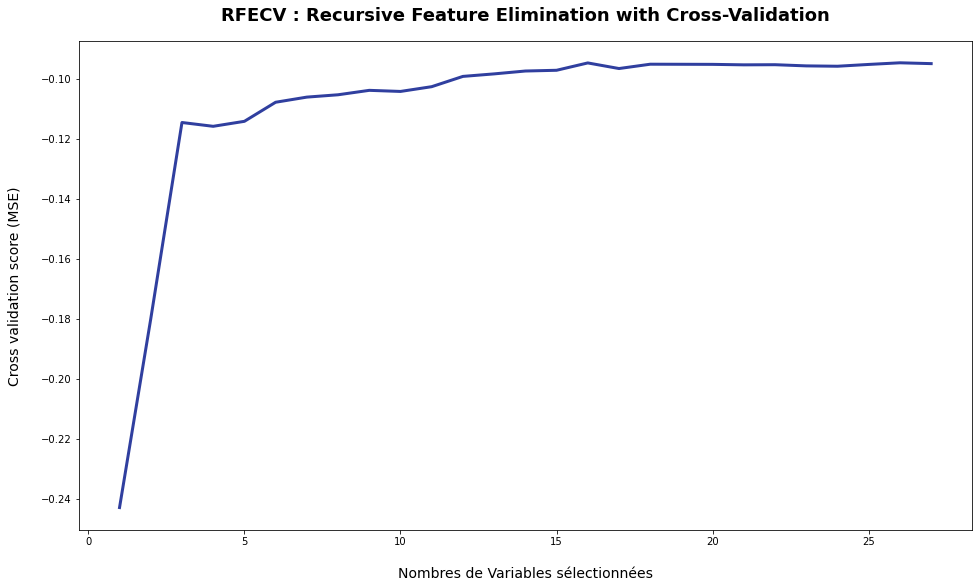


Les variables non indispensables :

Index(['Comments'], dtype='object')


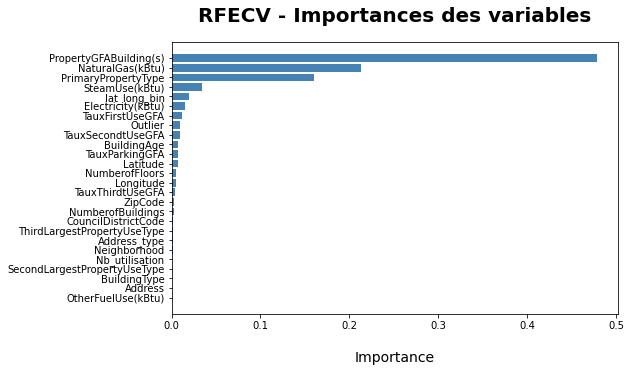

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_optimise_rfe,0.73357,0.09108,0.30180,0.23484,0.23484,83.12273,3.03608,0.76498,0.06246,0.09028,0.92625,0.00215,0.02938
GB_optimise_rfe,0.74055,0.08870,0.29782,0.23297,0.23297,83.26603,3.67573,0.76358,0.06469,0.09070,0.92652,0.00232,0.02927


In [251]:
df_resultats_rfe, y_pred_gb_optimise, gb_optimise_rfe = outils_model.calcul_plot_rfecv(
    gb_optimise_rfe, sans_ess_gb_opt, 'GB_optimise_rfe_sans_ess_reduit',
    X_train_sans_ess_log, X_test_sans_ess_log, 
    y_train_sans_ess_log, y_test_sans_ess_log,  df_resultats_rfe)

### <span style='background:PowderBlue'>7.3. Comparaison</span>

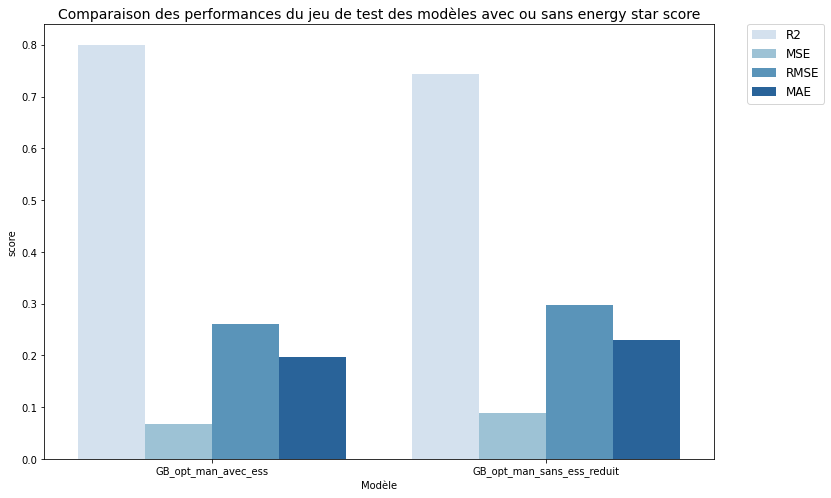

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_opt_man_avec_ess,0.80009,0.06834,0.26143,0.19720,0.19720,86.32559,0.60037,0.81856,0.04471,0.06962,0.95030,0.00182,0.01979
GB_opt_man_sans_ess_reduit,0.74292,0.08789,0.29646,0.23019,0.23019,83.52972,5.31093,0.77000,0.06009,0.08842,0.92954,0.00203,0.02807


In [243]:
# Comparaison visuelle des 4 algorithmes les plus performants
df_comp_ess = df_resultats_gb[df_resultats_gb['Modèle'].isin(
    ['GB_opt_man_avec_ess', 'GB_opt_man_sans_ess_reduit'])]
comparaison_score_melt = pd.melt(df_comp_ess, id_vars=[
                                 'Modèle'], value_name='score', value_vars=['R2', 'MSE', 'RMSE', 'MAE'])
# Visualisation
plt.figure(figsize=(12, 8))
sns.barplot(x=comparaison_score_melt['Modèle'],
            y=comparaison_score_melt['score'], hue=comparaison_score_melt['variable'], palette='Blues')
plt.title(
    'Comparaison des performances du jeu de test des modèles avec ou sans energy star score', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.show()

df_comp_ess.style.hide_index()

**Bilan**:
***
- L'ajout de la variable EnargyStar Score **améliore la performance** d'environ 7% de hausse pour le score R2 et 28% de baisse pour la MSE mais la variable est **très fastidieuse** et très couteuse à obtenir.
Il faudra donc voir avec les décideurs de l'intérêt en prenant en compte le coût par rapport 7% de performance en plus et le bénéfice de la baisse de 28% de MSE......

## <span style='background:Thistle'>9. Compléments</span>

### <span style='background:PowderBlue'>9.1. Effet de la standardisation</span>

**Test de plusieurs normalisation différentes**

In [127]:
# Modèle optimisé
model = GradientBoostingRegressor(random_state=seed,
                                  learning_rate=0.005,
                                  n_estimators=1400,
                                  max_depth=7,
                                  min_samples_split=101,
                                  subsample=0.65,
                                  min_samples_leaf=1,
                                  max_features=None)

In [128]:
X_train_test, X_test_test, y_train_test, y_test_test = train_test_split(
    X, y_log, test_size=0.2, random_state=seed)

<span style='background:PaleGreen'>**Effet de la normalisation/Standardisation**</span>

In [129]:
# Création d'un dataframe stockant les résultats des différents algorithmes
df_tests = pd.DataFrame(dtype='object')

**Test1** - num : StandardScaler / cat : TargetEncoder

In [130]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder()),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),  # standardization
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [131]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests, y_pred_test1 = outils_model.process_regression(gb,
                                                         X_train_test, X_test_test,
                                                         y_train_test, y_test_test,
                                                         df_tests,
                                                         'GB_test1',
                                                         True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_test1,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.44949,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737


**Test2** - num : StandardScaler / cat : TargetEncoder/StandardScaler

In [132]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder()),  # target encoding
    ('scaler', StandardScaler()),  # standardisation après target encodage
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),  # standardisation
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [133]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests, y_pred_test2 = outils_model.process_regression(gb,
                                                         X_train_test, X_test_test,
                                                         y_train_test, y_test_test,
                                                         df_tests,
                                                         'GB_test2',
                                                         True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_test1,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.44949,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test2,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.24415,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737


**Test3** - num :  MaxAbsScaler/ cat : TargetEncoder

In [134]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder()),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', MaxAbsScaler()),  # standardisation
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [135]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests, y_pred_test3 = outils_model.process_regression(gb,
                                                         X_train_test, X_test_test,
                                                         y_train_test, y_test_test,
                                                         df_tests,
                                                         'GB_test3',
                                                         True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_test1,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.44949,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test2,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.24415,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test3,0.74544,0.09239,0.30395,0.23065,0.23065,82.39814,6.62749,0.71295,0.04195,0.11931,0.86254,0.00210,0.05745


**Test4** - num : MinMaxScaler / cat : TargetEncoder

In [136]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder()),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),  # standardisation
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [137]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests, y_pred_test4 = outils_model.process_regression(gb,
                                                         X_train_test, X_test_test,
                                                         y_train_test, y_test_test,
                                                         df_tests,
                                                         'GB_test4',
                                                         True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_test1,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.44949,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test2,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.24415,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test3,0.74544,0.09239,0.30395,0.23065,0.23065,82.39814,6.62749,0.71295,0.04195,0.11931,0.86254,0.00210,0.05745
GB_test4,0.74609,0.09215,0.30357,0.23017,0.23017,82.45508,4.58038,0.71246,0.04225,0.11951,0.86265,0.00207,0.05740


**Test5** - num : Normalizer / cat : TargetEncoder

In [138]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder()),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', Normalizer()),  # standardisation
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [139]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests, y_pred_test5 = outils_model.process_regression(gb,
                                                         X_train_test, X_test_test,
                                                         y_train_test, y_test_test,
                                                         df_tests,
                                                         'GB_test5',
                                                         True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_test1,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.44949,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test2,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.24415,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test3,0.74544,0.09239,0.30395,0.23065,0.23065,82.39814,6.62749,0.71295,0.04195,0.11931,0.86254,0.00210,0.05745
GB_test4,0.74609,0.09215,0.30357,0.23017,0.23017,82.45508,4.58038,0.71246,0.04225,0.11951,0.86265,0.00207,0.05740
GB_test5,0.74192,0.09367,0.30605,0.23150,0.23150,81.77893,6.15750,0.70668,0.04028,0.12200,0.85847,0.00207,0.05914


**Test6** - num : QuantileTransformer normal/ cat : TargetEncoder

In [140]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder()),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', QuantileTransformer(output_distribution='normal')),  # standardisation
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [141]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests, y_pred_test6 = outils_model.process_regression(gb,
                                                         X_train_test, X_test_test,
                                                         y_train_test, y_test_test,
                                                         df_tests,
                                                         'GB_test6',
                                                         True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_test1,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.44949,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test2,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.24415,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test3,0.74544,0.09239,0.30395,0.23065,0.23065,82.39814,6.62749,0.71295,0.04195,0.11931,0.86254,0.00210,0.05745
GB_test4,0.74609,0.09215,0.30357,0.23017,0.23017,82.45508,4.58038,0.71246,0.04225,0.11951,0.86265,0.00207,0.05740
GB_test5,0.74192,0.09367,0.30605,0.23150,0.23150,81.77893,6.15750,0.70668,0.04028,0.12200,0.85847,0.00207,0.05914
GB_test6,0.74523,0.09247,0.30408,0.23038,0.23038,82.46112,4.69891,0.71286,0.04209,0.11932,0.86256,0.00218,0.05744


**Test7** - num : QuantileTransformer uniform/ cat : TargetEncoder

In [142]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder()),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', QuantileTransformer(output_distribution='uniform')),  # standardisation
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [143]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests, y_pred_test7 = outils_model.process_regression(gb,
                                                         X_train_test, X_test_test,
                                                         y_train_test, y_test_test,
                                                         df_tests,
                                                         'GB_test7',
                                                         True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_test1,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.44949,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test2,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.24415,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test3,0.74544,0.09239,0.30395,0.23065,0.23065,82.39814,6.62749,0.71295,0.04195,0.11931,0.86254,0.00210,0.05745
GB_test4,0.74609,0.09215,0.30357,0.23017,0.23017,82.45508,4.58038,0.71246,0.04225,0.11951,0.86265,0.00207,0.05740
GB_test5,0.74192,0.09367,0.30605,0.23150,0.23150,81.77893,6.15750,0.70668,0.04028,0.12200,0.85847,0.00207,0.05914
GB_test6,0.74523,0.09247,0.30408,0.23038,0.23038,82.46112,4.69891,0.71286,0.04209,0.11932,0.86256,0.00218,0.05744
GB_test7,0.74565,0.09231,0.30383,0.23057,0.23057,82.39853,4.73041,0.71327,0.04199,0.11918,0.86262,0.00214,0.05741


**Test8** - num : QuantileTransformer uniform/ cat : TargetEncoder

In [144]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder()),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', QuantileTransformer(output_distribution='uniform')),  # standardisation
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [145]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests, y_pred_test8 = outils_model.process_regression(gb,
                                                         X_train_test, X_test_test,
                                                         y_train_test, y_test_test,
                                                         df_tests,
                                                         'GB_test8',
                                                         True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_test1,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.44949,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test2,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.24415,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test3,0.74544,0.09239,0.30395,0.23065,0.23065,82.39814,6.62749,0.71295,0.04195,0.11931,0.86254,0.00210,0.05745
GB_test4,0.74609,0.09215,0.30357,0.23017,0.23017,82.45508,4.58038,0.71246,0.04225,0.11951,0.86265,0.00207,0.05740
GB_test5,0.74192,0.09367,0.30605,0.23150,0.23150,81.77893,6.15750,0.70668,0.04028,0.12200,0.85847,0.00207,0.05914
GB_test6,0.74523,0.09247,0.30408,0.23038,0.23038,82.46112,4.69891,0.71286,0.04209,0.11932,0.86256,0.00218,0.05744
GB_test7,0.74565,0.09231,0.30383,0.23057,0.23057,82.39853,4.73041,0.71327,0.04199,0.11918,0.86262,0.00214,0.05741
GB_test7,0.74565,0.09231,0.30383,0.23057,0.23057,82.39853,4.66195,0.71327,0.04199,0.11918,0.86262,0.00214,0.05741


**Test9** - num : PowerTransformer yeo-johnson/ cat : TargetEncoder

In [146]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder()),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', PowerTransformer(method='yeo-johnson')),  # standardisation
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [147]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests, y_pred_test9 = outils_model.process_regression(gb,
                                                         X_train_test, X_test_test,
                                                         y_train_test, y_test_test,
                                                         df_tests,
                                                         'GB_test9',
                                                         True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_test1,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.44949,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test2,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.24415,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test3,0.74544,0.09239,0.30395,0.23065,0.23065,82.39814,6.62749,0.71295,0.04195,0.11931,0.86254,0.00210,0.05745
GB_test4,0.74609,0.09215,0.30357,0.23017,0.23017,82.45508,4.58038,0.71246,0.04225,0.11951,0.86265,0.00207,0.05740
GB_test5,0.74192,0.09367,0.30605,0.23150,0.23150,81.77893,6.15750,0.70668,0.04028,0.12200,0.85847,0.00207,0.05914
GB_test6,0.74523,0.09247,0.30408,0.23038,0.23038,82.46112,4.69891,0.71286,0.04209,0.11932,0.86256,0.00218,0.05744
GB_test7,0.74565,0.09231,0.30383,0.23057,0.23057,82.39853,4.73041,0.71327,0.04199,0.11918,0.86262,0.00214,0.05741
GB_test7,0.74565,0.09231,0.30383,0.23057,0.23057,82.39853,4.66195,0.71327,0.04199,0.11918,0.86262,0.00214,0.05741
GB_test8,0.63397,0.13284,0.36448,0.27982,0.27982,78.74718,4.33089,0.57884,0.05181,0.17494,0.78645,0.00291,0.08924


**Test10** - num : RobustScaler/ cat : TargetEncoder

In [148]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder()),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler()),  # standardisation
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [149]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests, y_pred_test10 = outils_model.process_regression(gb,
                                                         X_train_test, X_test_test,
                                                         y_train_test, y_test_test,
                                                         df_tests,
                                                         'GB_test10',
                                                         True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_test1,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.44949,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test2,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.24415,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test3,0.74544,0.09239,0.30395,0.23065,0.23065,82.39814,6.62749,0.71295,0.04195,0.11931,0.86254,0.00210,0.05745
GB_test4,0.74609,0.09215,0.30357,0.23017,0.23017,82.45508,4.58038,0.71246,0.04225,0.11951,0.86265,0.00207,0.05740
GB_test5,0.74192,0.09367,0.30605,0.23150,0.23150,81.77893,6.15750,0.70668,0.04028,0.12200,0.85847,0.00207,0.05914
GB_test6,0.74523,0.09247,0.30408,0.23038,0.23038,82.46112,4.69891,0.71286,0.04209,0.11932,0.86256,0.00218,0.05744
GB_test7,0.74565,0.09231,0.30383,0.23057,0.23057,82.39853,4.73041,0.71327,0.04199,0.11918,0.86262,0.00214,0.05741
GB_test7,0.74565,0.09231,0.30383,0.23057,0.23057,82.39853,4.66195,0.71327,0.04199,0.11918,0.86262,0.00214,0.05741
GB_test8,0.63397,0.13284,0.36448,0.27982,0.27982,78.74718,4.33089,0.57884,0.05181,0.17494,0.78645,0.00291,0.08924
GB_test9,0.74531,0.09244,0.30403,0.23057,0.23057,82.43947,4.65132,0.71233,0.04239,0.11956,0.86270,0.00212,0.05738


**Test11** - num : RobustScaler/ cat : TargetEncoder/RobustScaler

In [150]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder()),  # target encoding
    ('scaler', RobustScaler()),  # standardisation
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler()),  # standardisation
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [151]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests, y_pred_test11 = outils_model.process_regression(gb,
                                                          X_train_test, X_test_test,
                                                          y_train_test, y_test_test,
                                                          df_tests,
                                                          'GB_test11',
                                                          True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_test1,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.44949,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test2,0.74557,0.09234,0.30388,0.23030,0.23030,82.41096,6.24415,0.71247,0.04240,0.11950,0.86273,0.00209,0.05737
GB_test3,0.74544,0.09239,0.30395,0.23065,0.23065,82.39814,6.62749,0.71295,0.04195,0.11931,0.86254,0.00210,0.05745
GB_test4,0.74609,0.09215,0.30357,0.23017,0.23017,82.45508,4.58038,0.71246,0.04225,0.11951,0.86265,0.00207,0.05740
GB_test5,0.74192,0.09367,0.30605,0.23150,0.23150,81.77893,6.15750,0.70668,0.04028,0.12200,0.85847,0.00207,0.05914
GB_test6,0.74523,0.09247,0.30408,0.23038,0.23038,82.46112,4.69891,0.71286,0.04209,0.11932,0.86256,0.00218,0.05744
GB_test7,0.74565,0.09231,0.30383,0.23057,0.23057,82.39853,4.73041,0.71327,0.04199,0.11918,0.86262,0.00214,0.05741
GB_test7,0.74565,0.09231,0.30383,0.23057,0.23057,82.39853,4.66195,0.71327,0.04199,0.11918,0.86262,0.00214,0.05741
GB_test8,0.63397,0.13284,0.36448,0.27982,0.27982,78.74718,4.33089,0.57884,0.05181,0.17494,0.78645,0.00291,0.08924
GB_test9,0.74531,0.09244,0.30403,0.23057,0.23057,82.43947,4.65132,0.71233,0.04239,0.11956,0.86270,0.00212,0.05738


**Bilan** :
***
- Le choix lors de l'analyse de la consommation totale après plusieurs essais, avait mis en avant **RobustScaler**. Le choix est identique pour la prédiction de l'émission à effet de gaz de serre.

### <span style='background:PowderBlue'>9.2. Effet de l'encodage</span>

<span style='background:PaleGreen'>**Effet de l'encodage**</span>

In [288]:
# Création d'un dataframe stockant les résultats des différents algorithmes
df_tests_enc = pd.DataFrame(dtype='object')

**Test1** - num : RobustScaler / cat : OneHotEncoder

In [287]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', OneHotEncoder(handle_unknown='ignore')),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler()),  # standardization
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [292]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests_enc, y_pred_enc_test1 = outils_model.process_regression(gb,
                                                                 X_train_test, X_test_test,
                                                                 y_train_test, y_test_test,
                                                                 df_tests_enc,
                                                                 'GB_enc_test1',
                                                                 True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_enc_test1,0.66452,0.12176,0.34894,0.26824,0.26824,76.70735,24.25528,0.66129,0.05040,0.14130,0.83195,0.00218,0.07023


**Test2** - num : RobustScaler / cat : HashingEncoder

In [293]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', HashingEncoder()),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler()),  # standardization
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [294]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests_enc, y_pred_enc_test2 = outils_model.process_regression(gb,
                                                                 X_train_test, X_test_test,
                                                                 y_train_test, y_test_test,
                                                                 df_tests_enc,
                                                                 'GB_enc_test2',
                                                                 True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_enc_test1,0.66452,0.12176,0.34894,0.26824,0.26824,76.70735,24.25528,0.66129,0.05040,0.14130,0.83195,0.00218,0.07023
GB_enc_test2,0.66452,0.12176,0.34894,0.26824,0.26824,76.70735,24.23897,0.66129,0.05040,0.14130,0.83195,0.00218,0.07023


**Test3** - num : RobustScaler / cat : OrdinalEncoder

In [295]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', OrdinalEncoder()),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler()),  # standardization
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [296]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests_enc, y_pred_enc_test3 = outils_model.process_regression(gb,
                                                                 X_train_test, X_test_test,
                                                                 y_train_test, y_test_test,
                                                                 df_tests_enc,
                                                                 'GB_enc_test3',
                                                                 True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_enc_test1,0.66452,0.12176,0.34894,0.26824,0.26824,76.70735,24.25528,0.66129,0.05040,0.14130,0.83195,0.00218,0.07023
GB_enc_test2,0.66452,0.12176,0.34894,0.26824,0.26824,76.70735,24.23897,0.66129,0.05040,0.14130,0.83195,0.00218,0.07023
GB_enc_test3,0.70959,0.10540,0.32466,0.24694,0.24694,81.72801,4.98801,0.70180,0.04046,0.12395,0.86074,0.00279,0.05820


**Test4** - num : RobustScaler / cat : LeaveOneOutEncoder

In [297]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', LeaveOneOutEncoder()),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler()),  # standardization
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [298]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests_enc, y_pred_enc_test4 = outils_model.process_regression(gb,
                                                                 X_train_test, X_test_test,
                                                                 y_train_test, y_test_test,
                                                                 df_tests_enc,
                                                                 'GB_enc_test4',
                                                                 True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_enc_test1,0.66452,0.12176,0.34894,0.26824,0.26824,76.70735,24.25528,0.66129,0.05040,0.14130,0.83195,0.00218,0.07023
GB_enc_test2,0.66452,0.12176,0.34894,0.26824,0.26824,76.70735,24.23897,0.66129,0.05040,0.14130,0.83195,0.00218,0.07023
GB_enc_test3,0.70959,0.10540,0.32466,0.24694,0.24694,81.72801,4.98801,0.70180,0.04046,0.12395,0.86074,0.00279,0.05820
GB_enc_test4,-0.00890,0.36617,0.60512,0.47699,0.47699,51.95766,7.61145,-0.01010,0.00890,0.42024,-0.00587,0.00130,0.42036


**Test5** - num : RobustScaler / cat : CatBoostEncoder

In [299]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', CatBoostEncoder()),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler()),  # standardization
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [300]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests_enc, y_pred_enc_test5 = outils_model.process_regression(gb,
                                                                 X_train_test, X_test_test,
                                                                 y_train_test, y_test_test,
                                                                 df_tests_enc,
                                                                 'GB_enc_test5',
                                                                 True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_enc_test1,0.66452,0.12176,0.34894,0.26824,0.26824,76.70735,24.25528,0.66129,0.05040,0.14130,0.83195,0.00218,0.07023
GB_enc_test2,0.66452,0.12176,0.34894,0.26824,0.26824,76.70735,24.23897,0.66129,0.05040,0.14130,0.83195,0.00218,0.07023
GB_enc_test3,0.70959,0.10540,0.32466,0.24694,0.24694,81.72801,4.98801,0.70180,0.04046,0.12395,0.86074,0.00279,0.05820
GB_enc_test4,-0.00890,0.36617,0.60512,0.47699,0.47699,51.95766,7.61145,-0.01010,0.00890,0.42024,-0.00587,0.00130,0.42036
GB_enc_test5,0.73333,0.09678,0.31110,0.23243,0.23243,81.98443,8.69236,0.70791,0.04178,0.12124,0.80730,0.00344,0.08054


**Test6** - num : RobustScaler / cat : PolynomialEncoder

In [301]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', PolynomialEncoder()),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler()),  # standardization
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [302]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests_enc, y_pred_enc_test6 = outils_model.process_regression(gb,
                                                                 X_train_test, X_test_test,
                                                                 y_train_test, y_test_test,
                                                                 df_tests_enc,
                                                                 'GB_enc_test6',
                                                                 True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_enc_test1,0.66452,0.12176,0.34894,0.26824,0.26824,76.70735,24.25528,0.66129,0.05040,0.14130,0.83195,0.00218,0.07023
GB_enc_test2,0.66452,0.12176,0.34894,0.26824,0.26824,76.70735,24.23897,0.66129,0.05040,0.14130,0.83195,0.00218,0.07023
GB_enc_test3,0.70959,0.10540,0.32466,0.24694,0.24694,81.72801,4.98801,0.70180,0.04046,0.12395,0.86074,0.00279,0.05820
GB_enc_test4,-0.00890,0.36617,0.60512,0.47699,0.47699,51.95766,7.61145,-0.01010,0.00890,0.42024,-0.00587,0.00130,0.42036
GB_enc_test5,0.73333,0.09678,0.31110,0.23243,0.23243,81.98443,8.69236,0.70791,0.04178,0.12124,0.80730,0.00344,0.08054
GB_enc_test6,0.73333,0.09678,0.31110,0.23243,0.23243,81.98443,8.65344,0.70791,0.04178,0.12124,0.80730,0.00344,0.08054


**Test7** - num : RobustScaler / cat : JamesSteinEncoder

In [303]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', JamesSteinEncoder()),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler()),  # standardization
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [304]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests_enc, y_pred_enc_test7 = outils_model.process_regression(gb,
                                                                 X_train_test, X_test_test,
                                                                 y_train_test, y_test_test,
                                                                 df_tests_enc,
                                                                 'GB_enc_test7',
                                                                 True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_enc_test1,0.66452,0.12176,0.34894,0.26824,0.26824,76.70735,24.25528,0.66129,0.05040,0.14130,0.83195,0.00218,0.07023
GB_enc_test2,0.66452,0.12176,0.34894,0.26824,0.26824,76.70735,24.23897,0.66129,0.05040,0.14130,0.83195,0.00218,0.07023
GB_enc_test3,0.70959,0.10540,0.32466,0.24694,0.24694,81.72801,4.98801,0.70180,0.04046,0.12395,0.86074,0.00279,0.05820
GB_enc_test4,-0.00890,0.36617,0.60512,0.47699,0.47699,51.95766,7.61145,-0.01010,0.00890,0.42024,-0.00587,0.00130,0.42036
GB_enc_test5,0.73333,0.09678,0.31110,0.23243,0.23243,81.98443,8.69236,0.70791,0.04178,0.12124,0.80730,0.00344,0.08054
GB_enc_test6,0.73333,0.09678,0.31110,0.23243,0.23243,81.98443,8.65344,0.70791,0.04178,0.12124,0.80730,0.00344,0.08054
GB_enc_test7,0.04111,0.34802,0.58993,0.46562,0.46562,53.20414,4.90768,0.02421,0.02353,0.40582,0.99784,0.00036,0.00090


**Test8** - num : RobustScaler / cat : HelmertEncoder

In [305]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', HelmertEncoder()),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler()),  # standardization
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [306]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests_enc, y_pred_enc_test8 = outils_model.process_regression(gb,
                                                                 X_train_test, X_test_test,
                                                                 y_train_test, y_test_test,
                                                                 df_tests_enc,
                                                                 'GB_enc_test8',
                                                                 True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_enc_test1,0.66452,0.12176,0.34894,0.26824,0.26824,76.70735,24.25528,0.66129,0.05040,0.14130,0.83195,0.00218,0.07023
GB_enc_test2,0.66452,0.12176,0.34894,0.26824,0.26824,76.70735,24.23897,0.66129,0.05040,0.14130,0.83195,0.00218,0.07023
GB_enc_test3,0.70959,0.10540,0.32466,0.24694,0.24694,81.72801,4.98801,0.70180,0.04046,0.12395,0.86074,0.00279,0.05820
GB_enc_test4,-0.00890,0.36617,0.60512,0.47699,0.47699,51.95766,7.61145,-0.01010,0.00890,0.42024,-0.00587,0.00130,0.42036
GB_enc_test5,0.73333,0.09678,0.31110,0.23243,0.23243,81.98443,8.69236,0.70791,0.04178,0.12124,0.80730,0.00344,0.08054
GB_enc_test6,0.73333,0.09678,0.31110,0.23243,0.23243,81.98443,8.65344,0.70791,0.04178,0.12124,0.80730,0.00344,0.08054
GB_enc_test7,0.04111,0.34802,0.58993,0.46562,0.46562,53.20414,4.90768,0.02421,0.02353,0.40582,0.99784,0.00036,0.00090
GB_enc_test8,0.74256,0.09343,0.30567,0.23260,0.23260,81.48695,68.70820,0.70966,0.04222,0.12057,0.86355,0.00255,0.05703


**Test9** - num : RobustScaler / cat : TargetEncoder

In [307]:
# Preprocessing pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder()),  # target encoding
])

# Preprocessing pipeline pour les variables quantitiatives
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler()),  # standardization
])

# Preprocessing column-wise using pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cols_cat),
    ('num', numeric_transformer, cols_num),
])

In [308]:
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', model)])

df_tests_enc, y_pred_enc_test9 = outils_model.process_regression(gb,
                                                                 X_train_test, X_test_test,
                                                                 y_train_test, y_test_test,
                                                                 df_tests_enc,
                                                                 'GB_enc_test9',
                                                                 True, False, False)

Modèle,R2,MSE,RMSE,MAE,Erreur moy,Précision,Durée,Test R2 CV,Test R2 +/-,Test MSE CV,Train R2 CV,Train R2 +/-,Train MSE CV
GB_enc_test1,0.66452,0.12176,0.34894,0.26824,0.26824,76.70735,24.25528,0.66129,0.05040,0.14130,0.83195,0.00218,0.07023
GB_enc_test2,0.66452,0.12176,0.34894,0.26824,0.26824,76.70735,24.23897,0.66129,0.05040,0.14130,0.83195,0.00218,0.07023
GB_enc_test3,0.70959,0.10540,0.32466,0.24694,0.24694,81.72801,4.98801,0.70180,0.04046,0.12395,0.86074,0.00279,0.05820
GB_enc_test4,-0.00890,0.36617,0.60512,0.47699,0.47699,51.95766,7.61145,-0.01010,0.00890,0.42024,-0.00587,0.00130,0.42036
GB_enc_test5,0.73333,0.09678,0.31110,0.23243,0.23243,81.98443,8.69236,0.70791,0.04178,0.12124,0.80730,0.00344,0.08054
GB_enc_test6,0.73333,0.09678,0.31110,0.23243,0.23243,81.98443,8.65344,0.70791,0.04178,0.12124,0.80730,0.00344,0.08054
GB_enc_test7,0.04111,0.34802,0.58993,0.46562,0.46562,53.20414,4.90768,0.02421,0.02353,0.40582,0.99784,0.00036,0.00090
GB_enc_test8,0.74256,0.09343,0.30567,0.23260,0.23260,81.48695,68.70820,0.70966,0.04222,0.12057,0.86355,0.00255,0.05703
GB_enc_test9,0.74478,0.09263,0.30435,0.23077,0.23077,82.39087,4.59034,0.71274,0.04219,0.11937,0.86272,0.00214,0.05737


**Bilan** :
***
RobustScaler est plus performant, il sera utilisé pour notre jeu de données pour prédire l'émission de CO2.